In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
# Load the dataset
df = pd.read_csv('data_sensors.csv')

# Inspect the first few rows and summary info
print("\nLabel counts:")
print(df['Label'].value_counts())


Label counts:
Label
3.0    20
2.0    10
1.0    10
Name: count, dtype: int64


In [2]:
# 1. Data Preparation
# Initialize RobustScaler
scaler = StandardScaler()
X = df.drop(columns=['Label']).values
# Scale the features
X = scaler.fit_transform(X)
# Replace NaN with -1 for LabelSpreading
y_train = df['Label'].fillna(-1).astype(int).values

In [6]:
# 2. Label Spreading
# We use 'knn' which is generally more robust for sensor data
lp_model = LabelSpreading(kernel='rbf', n_neighbors=3, alpha=0.7)
lp_model.fit(X, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


LabelSpreading(alpha=0.7, n_neighbors=3)

In [7]:
# 3. Confidence Thresholding
# Get the probability distributions
probs = lp_model.label_distributions_
max_probs = np.max(probs, axis=1)

In [8]:
# Threshold for "trusting" a label

trusted_mask = (max_probs >= threshold) | (y_train != -1) # Trust original labels + high confidence ones

# Pseudo-labels assigned by the model
pseudo_labels = lp_model.transduction_

In [9]:
# Count how many we are keeping
total_points = len(y_train)
labeled_initially = np.sum(y_train != -1)
newly_labeled = np.sum((y_train == -1) & (max_probs >= threshold))
uncertain_points = np.sum((y_train == -1) & (max_probs < threshold))

print(f"Total samples: {total_points}")
print(f"Initially labeled: {labeled_initially}")
print(f"Newly labeled (confidence > {threshold}): {newly_labeled}")
print(f"Uncertain samples (rejected): {uncertain_points}")

Total samples: 1600
Initially labeled: 40
Newly labeled (confidence > 0.85): 1324
Uncertain samples (rejected): 236


In [10]:
# 4. Train Production Classifier
# We only train on the points we 'trust'
X_prod = X[trusted_mask]
y_prod = pseudo_labels[trusted_mask]

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_prod, y_prod)

print("\nProduction Model trained successfully on trusted data.")


Production Model trained successfully on trusted data.


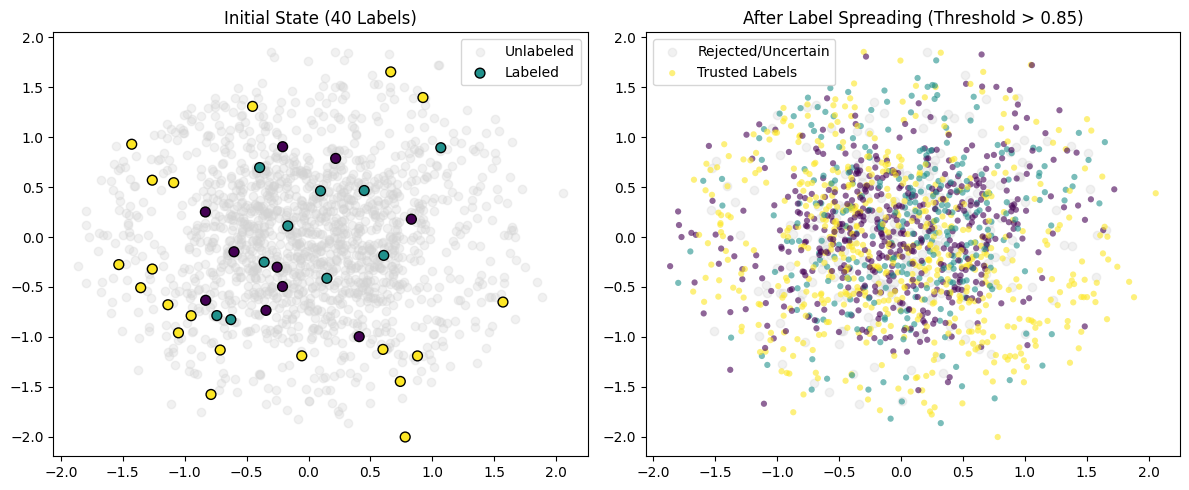

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 5))

# Plot 1: Initial Labels
plt.subplot(1, 2, 1)
mask_labeled = (y_train != -1)
plt.scatter(X_pca[~mask_labeled, 0], X_pca[~mask_labeled, 1], c='lightgrey', alpha=0.3, label='Unlabeled')
scatter1 = plt.scatter(X_pca[mask_labeled, 0], X_pca[mask_labeled, 1], c=y_train[mask_labeled], cmap='viridis', edgecolors='k', s=50, label='Labeled')
plt.title('Initial State (40 Labels)')
plt.legend()

# Plot 2: After Label Spreading (Trusted Labels)
plt.subplot(1, 2, 2)
plt.scatter(X_pca[~trusted_mask, 0], X_pca[~trusted_mask, 1], c='lightgrey', alpha=0.3, label='Rejected/Uncertain')
scatter2 = plt.scatter(X_pca[trusted_mask, 0], X_pca[trusted_mask, 1], c=pseudo_labels[trusted_mask], cmap='viridis', edgecolors='none', s=20, alpha=0.6, label='Trusted Labels')
plt.title(f'After Label Spreading (Threshold > {threshold})')
plt.legend()

plt.tight_layout()
plt.savefig('label_spreading_results.png')

# Output the fileTag for CSV of the pseudo-labeled data if needed
output_df = pd.DataFrame(X, columns=[f'Sensor {i}' for i in range(20)])
output_df['Initial_Label'] = df['Label']
output_df['Pseudo_Label'] = pseudo_labels
output_df['Confidence'] = max_probs
output_df.to_csv('pseudo_labeled_sensors.csv', index=False)

In [13]:
# Example prediction
example_idx = 5
example_features = X[example_idx].reshape(1, -1)
pred = rf_clf.predict(example_features)
prob = rf_clf.predict_proba(example_features)
print(f"RF Example prediction for first row: Label {pred[0]} with probability {np.max(prob):.2f}")
lp_pred = lp_model.predict(example_features)
lp_prob = lp_model.predict_proba(example_features)
print(f"LS Example prediction for first row: Label {lp_pred[0]} with probability {np.max(lp_prob):.2f}")


RF Example prediction for first row: Label 3 with probability 0.90
LS Example prediction for first row: Label 3 with probability 1.00


# Task
Split the `data_sensors.csv` dataset into a 10% holdout set for evaluation and the remaining data for semi-supervised learning. Then, retrain the Label Spreading model on the semi-supervised set, apply confidence thresholding (0.85) to generate trusted pseudo-labels, and train a RandomForestClassifier using these trusted labels. Finally, evaluate the performance of this RandomForestClassifier on the holdout set using `classification_report` and `accuracy_score`, and summarize the results.

## Split Data into Label Spreading Set and Holdout Set

### Subtask:
Identify the initially labeled data points. From these, create a 10% holdout set for final evaluation. The remaining 90% of labeled data, combined with all initially unlabeled data, will form the input for the Label Spreading algorithm. Store the features and true labels for the holdout set. For the Label Spreading input, set the labels of the holdout points to -1.


**Reasoning**:
The first step is to import the `train_test_split` function from `sklearn.model_selection` to facilitate splitting the data into training and holdout sets.



In [3]:
from sklearn.model_selection import train_test_split

# Identify initially labeled data points
labeled_indices = np.where(y_train != -1)[0]

# Split indices of initially labeled data into 90% for LS input and 10% for holdout
ls_input_labeled_indices, holdout_indices = train_test_split(
    labeled_indices, test_size=0.20, random_state=42, stratify=y_train[labeled_indices]
)

# Create X_test_holdout and y_test_holdout
X_test_holdout = X[holdout_indices]
y_test_holdout = y_train[holdout_indices]

# Create y_ls_input by making a copy of the original y_train
y_ls_input = np.copy(y_train)

# Set the labels at the holdout indices in y_ls_input to -1
y_ls_input[holdout_indices] = -1

print("Data split into Label Spreading input and holdout set successfully.")
print(f"Holdout set size: {len(holdout_indices)} samples")
print(f"Label Spreading input (including original unlabeled and 90% of original labeled): {len(y_ls_input)} samples")

Data split into Label Spreading input and holdout set successfully.
Holdout set size: 8 samples
Label Spreading input (including original unlabeled and 90% of original labeled): 1600 samples


In [29]:
lp_model_new = LabelSpreading(kernel='rbf' , alpha=0.9)
lp_model_new.fit(X, y_ls_input)

# Extract the probability distributions (label_distributions_)
probs_new = lp_model_new.label_distributions_

# Extract the pseudo-labels (transduction_)
pseudo_labels_new = lp_model_new.transduction_

print("New Label Spreading model fitted and pseudo-labels/probabilities extracted.")

New Label Spreading model fitted and pseudo-labels/probabilities extracted.


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


In [30]:
max_probs_new = np.max(probs_new, axis=1)

# Define the confidence threshold
threshold = 0.85 # Already defined but good to reiterate for clarity

# Create a new trusted mask. Points are trusted if:
# 1. They were originally labeled (not -1 in y_ls_input)
# 2. They have a high confidence score from Label Spreading (max_probs_new >= threshold)
trusted_mask_new = (max_probs_new >= threshold) | (y_ls_input != -1)

# Pseudo-labels assigned by the new model
pseudo_labels_final = pseudo_labels_new

# Print counts for verification
total_points = len(y_ls_input)
initial_labeled_ls_input = np.sum(y_ls_input != -1)
newly_labeled_trusted = np.sum((y_ls_input == -1) & (max_probs_new >= threshold))
uncertain_points_new = np.sum((y_ls_input == -1) & (max_probs_new < threshold))

print(f"Total samples for Label Spreading input: {total_points}")
print(f"Initially labeled in LS input (pre-thresholding): {initial_labeled_ls_input}")
print(f"Newly pseudo-labeled and trusted (confidence > {threshold}): {newly_labeled_trusted}")
print(f"Uncertain samples (rejected from LS input): {uncertain_points_new}")
print(f"Total trusted samples for production model training: {np.sum(trusted_mask_new)}")

Total samples for Label Spreading input: 1600
Initially labeled in LS input (pre-thresholding): 32
Newly pseudo-labeled and trusted (confidence > 0.85): 1318
Uncertain samples (rejected from LS input): 250
Total trusted samples for production model training: 1350


**Reasoning**:
Now that we have identified the trusted samples and their corresponding pseudo-labels using the new Label Spreading model and confidence thresholding, the next step is to train the production classifier. This involves using the `X` features filtered by `trusted_mask_new` and the `pseudo_labels_final` also filtered by `trusted_mask_new` to train a `RandomForestClassifier`.



In [31]:
X_prod_new = X[trusted_mask_new]
y_prod_new = pseudo_labels_final[trusted_mask_new]

rf_clf_new = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_new.fit(X_prod_new, y_prod_new)

print("New Production Model trained successfully on updated trusted data.")

New Production Model trained successfully on updated trusted data.


**Reasoning**:
Now that the new production model has been trained, the final step of the subtask is to evaluate its performance on the previously separated holdout set using `classification_report` and `accuracy_score`. This will provide a comprehensive summary of the model's performance.



In [32]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the holdout set
y_pred_holdout = rf_clf_new.predict(X_test_holdout)

# Evaluate the model
accuracy = accuracy_score(y_test_holdout, y_pred_holdout)
report = classification_report(y_test_holdout, y_pred_holdout)

print(f"\nAccuracy on Holdout Set: {accuracy:.4f}")
print("\nClassification Report on Holdout Set:\n")
print(report)


Accuracy on Holdout Set: 0.2500

Classification Report on Holdout Set:

              precision    recall  f1-score   support

           1       0.25      0.50      0.33         2
           2       0.00      0.00      0.00         2
           3       0.50      0.25      0.33         4

    accuracy                           0.25         8
   macro avg       0.25      0.25      0.22         8
weighted avg       0.31      0.25      0.25         8



# Task
Prepare the features (`X_true_labeled`) and true labels (`y_true_labeled`) for the initially labeled samples from `df`, to be used in stratified cross-validation.

## Prepare Data for Stratified Cross-Validation

### Subtask:
Identify and isolate the features (X_true_labeled) and true labels (y_true_labeled) corresponding only to the initially labeled samples from the original df.


**Reasoning**:
The subtask requires identifying and isolating the features and true labels of the initially labeled samples. This step will extract the indices of these labeled samples from `y_train`.



In [7]:
true_labeled_indices = np.where(y_train != -1)[0]
X_true_labeled = X[true_labeled_indices]
y_true_labeled = df['Label'].iloc[true_labeled_indices].values

print(f"Shape of X_true_labeled: {X_true_labeled.shape}")
print(f"Shape of y_true_labeled: {y_true_labeled.shape}")

Shape of X_true_labeled: (40, 20)
Shape of y_true_labeled: (40,)


# Task
Perform a Repeated Stratified K-Fold Cross-Validation (e.g., 5 splits, 5 repeats) on the `data_sensors.csv` dataset to evaluate the semi-supervised learning pipeline. For each fold and repeat, train a `LabelSpreading` model (kernel='rbf', n_neighbors=3, alpha=0.7) to generate trusted pseudo-labels (confidence threshold 0.85), then train a `RandomForestClassifier` (n_estimators=100, random_state=42) on these pseudo-labels, and finally, evaluate the RandomForestClassifier's performance on the true labeled test set of that fold using `accuracy_score` and `classification_report`. Aggregate and summarize the results by reporting the overall mean accuracy and its standard deviation, along with an averaged classification report across all folds and repeats.

## Initialize Repeated Stratified K-Fold Cross-Validation

### Subtask:
Set up a `RepeatedStratifiedKFold` object with a specified number of splits (e.g., 5) and a specified number of repeats (e.g., 5), ensuring that each fold maintains the proportion of classes from the true labeled data. Shuffle the data for randomness before splitting, using a `random_state` for reproducibility.


**Reasoning**:
The subtask requires importing `RepeatedStratifiedKFold` and initializing it with the specified parameters to prepare for repeated stratified cross-validation.



In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold

# Initialize RepeatedStratifiedKFold with 5 splits, 5 repeats, shuffling, and a random state
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

print("RepeatedStratifiedKFold object initialized successfully.")

RepeatedStratifiedKFold object initialized successfully.


## Perform Repeated Cross-Validation Loop

### Subtask:
Iterate through each repeat and each fold of the RepeatedStratifiedKFold. For each fold, prepare fold-specific semi-supervised data, run Label Spreading, generate trusted pseudo-labels, train a RandomForestClassifier, and evaluate its performance on the true labeled test set of the current fold. Store the accuracy and classification report for each fold and repeat.


**Reasoning**:
I need to implement the repeated cross-validation loop as described in the instructions. This involves iterating through each fold and repeat generated by `RepeatedStratifiedKFold`, preparing the data for semi-supervised learning, training the Label Spreading model, generating trusted pseudo-labels, training a RandomForestClassifier, and then evaluating it on the true labeled test set of the current fold. I will store the accuracy and classification report for each fold and repeat in the `all_accuracies` and `all_reports` lists.



In [14]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

all_accuracies = []
all_reports = []

# Assumptions from your code context:
# - X: full feature matrix for ALL samples (labeled + unlabeled)
# - y_train: labels for ALL samples, with -1 for unlabeled (your SSL input labels)
# - true_labeled_indices: global indices into X for the "true labeled" subset used for evaluation
# - X_true_labeled = X[true_labeled_indices]
# - y_true_labeled: true labels aligned with X_true_labeled
# - rskf splits are over (X_true_labeled, y_true_labeled)
# - threshold is defined, e.g. 0.9

for fold_idx, (train_idx_local, test_idx_local) in enumerate(rskf.split(X_true_labeled, y_true_labeled)):
    print(f"\n--- Fold {fold_idx+1}/{rskf.get_n_splits()} ---")

    # Map local fold indices (in X_true_labeled) back to global indices (in X)
    train_idx_global = true_labeled_indices[train_idx_local]
    test_idx_global  = true_labeled_indices[test_idx_local]

    # Define the SSL training pool: ALL samples except the fold's true-labeled test items
    # (this matches your original intent: you can use the rest of the world, including unlabeled + other labeled)
    ssl_train_mask = np.ones(X.shape[0], dtype=bool)
    ssl_train_mask[test_idx_global] = False

    X_ssl_train = X[ssl_train_mask]
    y_ssl_input = np.copy(y_train[ssl_train_mask])

    # IMPORTANT: Ensure the fold's test items are not present in SSL training pool at all
    # (We already removed them via ssl_train_mask)

    # Fit LabelSpreading ONLY on SSL training pool
    lp_model_fold = LabelSpreading(kernel="rbf", alpha=0.9, max_iter=100, gamma=1e-5)
    lp_model_fold.fit(X_ssl_train, y_ssl_input)

    probs = lp_model_fold.label_distributions_
    transduction = lp_model_fold.transduction_
    max_probs = probs.max(axis=1)

    # Trusted samples are: originally labeled OR high-confidence pseudo-labeled (within SSL training pool only)
    trusted_mask = (y_ssl_input != -1) | (max_probs >= threshold)

    X_prod = X_ssl_train[trusted_mask]
    y_prod = transduction[trusted_mask]

    unique, counts = np.unique(y_prod, return_counts=True)
    print("Training class counts in y_prod:", dict(zip(unique, counts)))
    print("Trusted fraction:", trusted_mask.mean())

    # Train RF ONLY on trusted subset from SSL training pool
    rf_clf_fold = RandomForestClassifier(
        n_estimators=800,
        min_samples_leaf=2,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1,
    )
    rf_clf_fold.fit(X_prod, y_prod)

    # Evaluate ONLY on the held-out true-labeled test fold (global indices)
    X_test_fold = X[test_idx_global]
    y_true_fold = y_true_labeled[test_idx_local]  # already aligned with test_idx_local

    y_pred_fold = rf_clf_fold.predict(X_test_fold)

    accuracy_fold = accuracy_score(y_true_fold, y_pred_fold)
    all_accuracies.append(accuracy_fold)
    print(f"Accuracy for Fold {fold_idx+1}: {accuracy_fold:.4f}")

    report_fold = classification_report(y_true_fold, y_pred_fold, output_dict=True, zero_division=0)
    all_reports.append(report_fold)
    print(classification_report(y_true_fold, y_pred_fold, zero_division=0))



--- Fold 1/25 ---
Training class counts in y_prod: {np.int64(1): np.int64(8), np.int64(2): np.int64(8), np.int64(3): np.int64(16)}
Trusted fraction: 0.020100502512562814
Accuracy for Fold 1: 0.6250
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.50      0.50      0.50         2
         3.0       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.70      0.58      0.61         8
weighted avg       0.68      0.62      0.62         8


--- Fold 2/25 ---
Training class counts in y_prod: {np.int64(1): np.int64(8), np.int64(2): np.int64(8), np.int64(3): np.int64(16)}
Trusted fraction: 0.020100502512562814
Accuracy for Fold 2: 0.7500
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         2
         2.0       1.00      0.50      0.67         2
         3.0       0.75      0.75      0.75         4

   

In [15]:
import numpy as np
from sklearn.metrics import classification_report

# Summarize cross-validation results
mean_accuracy_rskf = np.mean(all_accuracies)
std_accuracy_rskf = np.std(all_accuracies)

print(f"\n--- Repeated Stratified K-Fold Cross-Validation Results Summary ---")
print(f"Overall Mean Accuracy: {mean_accuracy_rskf:.4f} (+/- {std_accuracy_rskf:.4f})")

# Aggregate classification reports
# Initialize dictionaries to store sums of metrics and supports
aggregated_report = {}
class_labels = sorted([float(k) for k in all_reports[0].keys() if k not in ['accuracy', 'macro avg', 'weighted avg']])

for label in class_labels:
    aggregated_report[str(label)] = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0}

# Sum metrics and supports from all reports
for report_dict in all_reports:
    for label in class_labels:
        str_label = str(label)
        if str_label in report_dict:
            aggregated_report[str_label]['precision'] += report_dict[str_label]['precision']
            aggregated_report[str_label]['recall'] += report_dict[str_label]['recall']
            aggregated_report[str_label]['f1-score'] += report_dict[str_label]['f1-score']
            aggregated_report[str_label]['support'] += report_dict[str_label]['support']

# Calculate average metrics
num_folds_repeats = len(all_reports)
for label in class_labels:
    str_label = str(label)
    aggregated_report[str_label]['precision'] /= num_folds_repeats
    aggregated_report[str_label]['recall'] /= num_folds_repeats
    aggregated_report[str_label]['f1-score'] /= num_folds_repeats
    # Note: 'support' is total count, not average, so no division needed if we want overall support

# Calculate average macro and weighted averages
macro_avg_precision = np.mean([r['macro avg']['precision'] for r in all_reports])
macro_avg_recall = np.mean([r['macro avg']['recall'] for r in all_reports])
macro_avg_f1 = np.mean([r['macro avg']['f1-score'] for r in all_reports])

weighted_avg_precision = np.mean([r['weighted avg']['precision'] for r in all_reports])
weighted_avg_recall = np.mean([r['weighted avg']['recall'] for r in all_reports])
weighted_avg_f1 = np.mean([r['weighted avg']['f1-score'] for r in all_reports])

aggregated_report['macro avg'] = {'precision': macro_avg_precision, 'recall': macro_avg_recall, 'f1-score': macro_avg_f1, 'support': None}
aggregated_report['weighted avg'] = {'precision': weighted_avg_precision, 'recall': weighted_avg_recall, 'f1-score': weighted_avg_f1, 'support': None}
aggregated_report['accuracy'] = mean_accuracy_rskf

# Re-format for pretty printing (optional, but good for display)
print("\nAggregated Classification Report (averaged across all folds and repeats):\n")

# Manual pretty printing of the aggregated report
# Find max length for class labels for alignment
max_label_len = max(len(str(label)) for label in class_labels + ['macro avg', 'weighted avg'])

header = f"{{:<{max_label_len}}} {{:>10}} {{:>10}} {{:>10}} {{:>10}}"
print(header.format("", "precision", "recall", "f1-score", "support"))
print("-" * (max_label_len + 4 * 10 + 3 * 2)) # Adjust length dynamically

for label in class_labels:
    str_label = str(label)
    metrics = aggregated_report[str_label]
    print(header.format(str_label, f"{metrics['precision']:.2f}", f"{metrics['recall']:.2f}", f"{metrics['f1-score']:.2f}", int(metrics['support'])))

print("\n" + "-" * (max_label_len + 4 * 10 + 3 * 2))
macro_metrics = aggregated_report['macro avg']
print(header.format("macro avg", f"{macro_metrics['precision']:.2f}", f"{macro_metrics['recall']:.2f}", f"{macro_metrics['f1-score']:.2f}", ""))
weighted_metrics = aggregated_report['weighted avg']
print(header.format("weighted avg", f"{weighted_metrics['precision']:.2f}", f"{weighted_metrics['recall']:.2f}", f"{weighted_metrics['f1-score']:.2f}", ""))
print("\n" + "-" * (max_label_len + 4 * 10 + 3 * 2))
print(f"{{:<{max_label_len}}} {{:>10.2f}}".format("accuracy", aggregated_report['accuracy']))

print("Repeated cross-validation results summarized.")


--- Repeated Stratified K-Fold Cross-Validation Results Summary ---
Overall Mean Accuracy: 0.6950 (+/- 0.1279)

Aggregated Classification Report (averaged across all folds and repeats):

              precision     recall   f1-score    support
----------------------------------------------------------
1.0                0.80       0.62       0.67         50
2.0                0.64       0.38       0.47         50
3.0                0.66       0.89       0.75        100

----------------------------------------------------------
macro avg          0.70       0.63       0.63           
weighted avg       0.69       0.69       0.66           

----------------------------------------------------------
accuracy           0.69
Repeated cross-validation results summarized.


### Per class pseudo label

In [10]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold


def aggregate_reports_mean(all_reports, mean_accuracy, std_accuracy):
    first = all_reports[0]
    class_keys = [k for k in first.keys() if k not in ("accuracy", "macro avg", "weighted avg")]
    class_keys = sorted(class_keys, key=lambda x: float(x))

    aggregated = {k: {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0} for k in class_keys}

    for r in all_reports:
        for k in class_keys:
            aggregated[k]["precision"] += r[k]["precision"]
            aggregated[k]["recall"] += r[k]["recall"]
            aggregated[k]["f1-score"] += r[k]["f1-score"]
            aggregated[k]["support"] += r[k]["support"]

    n = len(all_reports)
    for k in class_keys:
        aggregated[k]["precision"] /= n
        aggregated[k]["recall"] /= n
        aggregated[k]["f1-score"] /= n

    aggregated["macro avg"] = {
        "precision": float(np.mean([r["macro avg"]["precision"] for r in all_reports])),
        "recall": float(np.mean([r["macro avg"]["recall"] for r in all_reports])),
        "f1-score": float(np.mean([r["macro avg"]["f1-score"] for r in all_reports])),
        "support": None,
    }
    aggregated["weighted avg"] = {
        "precision": float(np.mean([r["weighted avg"]["precision"] for r in all_reports])),
        "recall": float(np.mean([r["weighted avg"]["recall"] for r in all_reports])),
        "f1-score": float(np.mean([r["weighted avg"]["f1-score"] for r in all_reports])),
        "support": None,
    }
    aggregated["accuracy"] = float(mean_accuracy)

    print("\n--- Repeated Stratified K-Fold Cross-Validation Results Summary ---")
    print(f"Overall Mean Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})\n")

    max_label_len = max(len(k) for k in class_keys + ["macro avg", "weighted avg"])
    header = f"{{:<{max_label_len}}} {{:>10}} {{:>10}} {{:>10}} {{:>14}}"
    print("Aggregated Classification Report (averaged across all folds and repeats):\n")
    print(header.format("", "precision", "recall", "f1-score", "support_total"))
    print("-" * (max_label_len + 10 + 10 + 10 + 14 + 3 * 2))

    for k in class_keys:
        m = aggregated[k]
        print(header.format(k, f"{m['precision']:.2f}", f"{m['recall']:.2f}", f"{m['f1-score']:.2f}", int(m["support"])))

    print("-" * (max_label_len + 10 + 10 + 10 + 14 + 3 * 2))
    m = aggregated["macro avg"]
    print(header.format("macro avg", f"{m['precision']:.2f}", f"{m['recall']:.2f}", f"{m['f1-score']:.2f}", ""))
    w = aggregated["weighted avg"]
    print(header.format("weighted avg", f"{w['precision']:.2f}", f"{w['recall']:.2f}", f"{w['f1-score']:.2f}", ""))
    print("-" * (max_label_len + 10 + 10 + 10 + 14 + 3 * 2))
    print(f"{'accuracy':<{max_label_len}} {aggregated['accuracy']:>10.2f}")
    print("Repeated cross-validation results summarized.")

    return aggregated


def build_ssl_labels_for_fold(n_total, true_labeled_indices, train_idx_local, y_true_labeled, unlabeled_value=-1):
    """
    Create a length-n_total label vector for SSL:
      - everything unlabeled by default
      - fold train portion of the true-labeled subset is labeled with its ground-truth label
    """
    y_ssl = np.full(n_total, unlabeled_value, dtype=y_true_labeled.dtype)

    train_idx_global = true_labeled_indices[train_idx_local]
    y_ssl[train_idx_global] = y_true_labeled[train_idx_local]
    return y_ssl


def trusted_by_threshold(y_ssl_input, probs, threshold):
    """Trusted = originally labeled OR max probability >= threshold."""
    max_probs = probs.max(axis=1)
    return (y_ssl_input != -1) | (max_probs >= threshold)


# -----------------------------
# MAIN (you must have X, true_labeled_indices, y_true_labeled defined)
# -----------------------------
n_splits = 5
n_repeats = 5
random_state = 42

# confidence threshold for adding pseudo-labels
threshold = 0.8

rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

X_true_labeled = X[true_labeled_indices]
print("-----------",len(X))
print("-----------",len(X_true_labeled))
all_accuracies = []
all_reports = []

for fold_idx, (train_idx_local, test_idx_local) in enumerate(rskf.split(X_true_labeled, y_true_labeled)):
    print(f"\n--- Fold {fold_idx+1}/{rskf.get_n_splits()} ---")

    test_idx_global = true_labeled_indices[test_idx_local]

    # Build fold-specific SSL seed labels (THIS is the key fix)
    y_ssl_full = build_ssl_labels_for_fold(
        n_total=X.shape[0],
        true_labeled_indices=true_labeled_indices,
        train_idx_local=train_idx_local,
        y_true_labeled=y_true_labeled,
        unlabeled_value=-1
    )
    print("----- SSL", len(y_ssl_full))
    # Exclude the fold test items from the SSL pool entirely (avoid feature leakage)
    ssl_train_mask = np.ones(X.shape[0], dtype=bool)
    ssl_train_mask[test_idx_global] = False

    X_ssl_train = X[ssl_train_mask]
    y_ssl_input = y_ssl_full[ssl_train_mask]

    print("------------",len(X_ssl_train), len(y_ssl_input))

    # Sanity check: ensure >1 class is present among labeled seeds
    labeled_vals = y_ssl_input[y_ssl_input != -1]
    print("Seed labeled class counts:", dict(zip(*np.unique(labeled_vals, return_counts=True))))

    # Fit LabelSpreading on SSL pool
    lp = LabelSpreading(kernel="knn", alpha=0.9, n_neighbors=7)
    lp.fit(X_ssl_train, y_ssl_input)

    probs = lp.label_distributions_
    transduction = lp.transduction_

    # Trust gating (same idea you had originally)
    trusted_mask = trusted_by_threshold(y_ssl_input, probs, threshold=threshold)

    X_prod = X_ssl_train[trusted_mask]
    y_prod = transduction[trusted_mask]

    print("------------",len(X_prod), len(y_prod))

    # Debug: what RF is learning from
    unique, counts = np.unique(y_prod, return_counts=True)
    print("Training class counts in y_prod:", dict(zip(unique, counts)))
    print("Trusted fraction:", trusted_mask.mean())

    # Train classifier
    rf = RandomForestClassifier(
        n_estimators=800,
        min_samples_leaf=2,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
    rf.fit(X_prod, y_prod)

    # Evaluate on held-out fold test items
    X_test_fold = X[test_idx_global]
    y_true_fold = y_true_labeled[test_idx_local]
    y_pred_fold = rf.predict(X_test_fold)

    acc = accuracy_score(y_true_fold, y_pred_fold)
    all_accuracies.append(acc)
    print(f"Accuracy for Fold {fold_idx+1}: {acc:.4f}")
    print(classification_report(y_true_fold, y_pred_fold, zero_division=0))

    all_reports.append(classification_report(y_true_fold, y_pred_fold, output_dict=True, zero_division=0))

mean_accuracy = float(np.mean(all_accuracies))
std_accuracy = float(np.std(all_accuracies))
_ = aggregate_reports_mean(all_reports, mean_accuracy, std_accuracy)


----------- 1600
----------- 40

--- Fold 1/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 154 154
Training class counts in y_prod: {np.float64(1.0): np.int64(45), np.float64(2.0): np.int64(25), np.float64(3.0): np.int64(84)}
Trusted fraction: 0.09673366834170855


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 1: 0.3750
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.50      0.50      0.50         2
         3.0       0.40      0.50      0.44         4

    accuracy                           0.38         8
   macro avg       0.30      0.33      0.31         8
weighted avg       0.33      0.38      0.35         8


--- Fold 2/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 140 140
Training class counts in y_prod: {np.float64(1.0): np.int64(55), np.float64(2.0): np.int64(28), np.float64(3.0): np.int64(57)}
Trusted fraction: 0.08793969849246232


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 2: 0.5000
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      0.50      0.50         4

    accuracy                           0.50         8
   macro avg       0.33      0.50      0.39         8
weighted avg       0.38      0.50      0.42         8


--- Fold 3/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 148 148
Training class counts in y_prod: {np.float64(1.0): np.int64(54), np.float64(2.0): np.int64(24), np.float64(3.0): np.int64(70)}
Trusted fraction: 0.09296482412060302


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 3: 0.3750
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.00      0.00      0.00         2
         3.0       0.40      0.50      0.44         4

    accuracy                           0.38         8
   macro avg       0.30      0.33      0.31         8
weighted avg       0.33      0.38      0.35         8


--- Fold 4/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 149 149
Training class counts in y_prod: {np.float64(1.0): np.int64(57), np.float64(2.0): np.int64(32), np.float64(3.0): np.int64(60)}
Trusted fraction: 0.0935929648241206


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 4: 0.6250
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.00      0.00      0.00         2
         3.0       0.67      1.00      0.80         4

    accuracy                           0.62         8
   macro avg       0.39      0.50      0.43         8
weighted avg       0.46      0.62      0.53         8


--- Fold 5/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 181 181
Training class counts in y_prod: {np.float64(1.0): np.int64(57), np.float64(2.0): np.int64(38), np.float64(3.0): np.int64(86)}
Trusted fraction: 0.11369346733668342


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 5: 0.5000
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8


--- Fold 6/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 183 183
Training class counts in y_prod: {np.float64(1.0): np.int64(62), np.float64(2.0): np.int64(31), np.float64(3.0): np.int64(90)}
Trusted fraction: 0.11494974874371859


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 6: 0.5000
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      0.75      0.60         4

    accuracy                           0.50         8
   macro avg       0.33      0.42      0.37         8
weighted avg       0.38      0.50      0.42         8


--- Fold 7/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 154 154
Training class counts in y_prod: {np.float64(1.0): np.int64(59), np.float64(2.0): np.int64(34), np.float64(3.0): np.int64(61)}
Trusted fraction: 0.09673366834170855


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 7: 0.7500
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         2
         2.0       1.00      0.50      0.67         2
         3.0       1.00      0.75      0.86         4

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.88      0.75      0.76         8


--- Fold 8/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 162 162
Training class counts in y_prod: {np.float64(1.0): np.int64(64), np.float64(2.0): np.int64(28), np.float64(3.0): np.int64(70)}
Trusted fraction: 0.10175879396984924


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 8: 0.6250
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       1.00      0.50      0.67         2
         3.0       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8


--- Fold 9/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 139 139
Training class counts in y_prod: {np.float64(1.0): np.int64(40), np.float64(2.0): np.int64(27), np.float64(3.0): np.int64(72)}
Trusted fraction: 0.08731155778894473


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 9: 0.6250
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8


--- Fold 10/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 140 140
Training class counts in y_prod: {np.float64(1.0): np.int64(49), np.float64(2.0): np.int64(27), np.float64(3.0): np.int64(64)}
Trusted fraction: 0.08793969849246232


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 10: 0.3750
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.43      0.75      0.55         4

    accuracy                           0.38         8
   macro avg       0.14      0.25      0.18         8
weighted avg       0.21      0.38      0.27         8


--- Fold 11/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 177 177
Training class counts in y_prod: {np.float64(1.0): np.int64(61), np.float64(2.0): np.int64(34), np.float64(3.0): np.int64(82)}
Trusted fraction: 0.11118090452261306


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 11: 0.3750
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.43      0.75      0.55         4

    accuracy                           0.38         8
   macro avg       0.14      0.25      0.18         8
weighted avg       0.21      0.38      0.27         8


--- Fold 12/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 137 137
Training class counts in y_prod: {np.float64(1.0): np.int64(52), np.float64(2.0): np.int64(29), np.float64(3.0): np.int64(56)}
Trusted fraction: 0.08605527638190955


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 12: 0.3750
              precision    recall  f1-score   support

         1.0       0.33      0.50      0.40         2
         2.0       0.00      0.00      0.00         2
         3.0       0.40      0.50      0.44         4

    accuracy                           0.38         8
   macro avg       0.24      0.33      0.28         8
weighted avg       0.28      0.38      0.32         8


--- Fold 13/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 156 156
Training class counts in y_prod: {np.float64(1.0): np.int64(65), np.float64(2.0): np.int64(28), np.float64(3.0): np.int64(63)}
Trusted fraction: 0.09798994974874371


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 13: 0.5000
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      0.75      0.60         4

    accuracy                           0.50         8
   macro avg       0.33      0.42      0.37         8
weighted avg       0.38      0.50      0.42         8


--- Fold 14/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 168 168
Training class counts in y_prod: {np.float64(1.0): np.int64(39), np.float64(2.0): np.int64(30), np.float64(3.0): np.int64(99)}
Trusted fraction: 0.10552763819095477


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 14: 0.6250
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8


--- Fold 15/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 162 162
Training class counts in y_prod: {np.float64(1.0): np.int64(59), np.float64(2.0): np.int64(29), np.float64(3.0): np.int64(74)}
Trusted fraction: 0.10175879396984924


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 15: 0.6250
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.50      0.50      0.50         2
         3.0       0.75      0.75      0.75         4

    accuracy                           0.62         8
   macro avg       0.58      0.58      0.58         8
weighted avg       0.62      0.62      0.62         8


--- Fold 16/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 139 139
Training class counts in y_prod: {np.float64(1.0): np.int64(39), np.float64(2.0): np.int64(31), np.float64(3.0): np.int64(69)}
Trusted fraction: 0.08731155778894473


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 16: 0.6250
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8


--- Fold 17/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 159 159
Training class counts in y_prod: {np.float64(1.0): np.int64(56), np.float64(2.0): np.int64(35), np.float64(3.0): np.int64(68)}
Trusted fraction: 0.09987437185929648


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 17: 0.5000
              precision    recall  f1-score   support

         1.0       0.33      0.50      0.40         2
         2.0       0.00      0.00      0.00         2
         3.0       0.60      0.75      0.67         4

    accuracy                           0.50         8
   macro avg       0.31      0.42      0.36         8
weighted avg       0.38      0.50      0.43         8


--- Fold 18/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 162 162
Training class counts in y_prod: {np.float64(1.0): np.int64(64), np.float64(2.0): np.int64(33), np.float64(3.0): np.int64(65)}
Trusted fraction: 0.10175879396984924


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 18: 0.6250
              precision    recall  f1-score   support

         1.0       0.33      0.50      0.40         2
         2.0       1.00      0.50      0.67         2
         3.0       0.75      0.75      0.75         4

    accuracy                           0.62         8
   macro avg       0.69      0.58      0.61         8
weighted avg       0.71      0.62      0.64         8


--- Fold 19/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 143 143
Training class counts in y_prod: {np.float64(1.0): np.int64(55), np.float64(2.0): np.int64(22), np.float64(3.0): np.int64(66)}
Trusted fraction: 0.08982412060301508


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 19: 0.1250
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.25      0.25      0.25         4

    accuracy                           0.12         8
   macro avg       0.08      0.08      0.08         8
weighted avg       0.12      0.12      0.12         8


--- Fold 20/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 164 164
Training class counts in y_prod: {np.float64(1.0): np.int64(51), np.float64(2.0): np.int64(33), np.float64(3.0): np.int64(80)}
Trusted fraction: 0.10301507537688442


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 20: 0.6250
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.52      0.50      0.46         8
weighted avg       0.54      0.62      0.53         8


--- Fold 21/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 140 140
Training class counts in y_prod: {np.float64(1.0): np.int64(55), np.float64(2.0): np.int64(24), np.float64(3.0): np.int64(61)}
Trusted fraction: 0.08793969849246232


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 21: 0.6250
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         2
         2.0       1.00      0.50      0.67         2
         3.0       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.72      0.67      0.63         8
weighted avg       0.71      0.62      0.62         8


--- Fold 22/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 159 159
Training class counts in y_prod: {np.float64(1.0): np.int64(58), np.float64(2.0): np.int64(35), np.float64(3.0): np.int64(66)}
Trusted fraction: 0.09987437185929648


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 22: 0.7500
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.67      1.00      0.80         4

    accuracy                           0.75         8
   macro avg       0.56      0.67      0.60         8
weighted avg       0.58      0.75      0.65         8


--- Fold 23/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 148 148
Training class counts in y_prod: {np.float64(1.0): np.int64(48), np.float64(2.0): np.int64(25), np.float64(3.0): np.int64(75)}
Trusted fraction: 0.09296482412060302


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 23: 0.5000
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8


--- Fold 24/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 162 162
Training class counts in y_prod: {np.float64(1.0): np.int64(62), np.float64(2.0): np.int64(30), np.float64(3.0): np.int64(70)}
Trusted fraction: 0.10175879396984924


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 24: 0.5000
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         2
         3.0       0.50      1.00      0.67         4

    accuracy                           0.50         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.25      0.50      0.33         8


--- Fold 25/25 ---
----- SSL 1600
------------ 1592 1592
Seed labeled class counts: {np.float64(1.0): np.int64(8), np.float64(2.0): np.int64(8), np.float64(3.0): np.int64(16)}
------------ 142 142
Training class counts in y_prod: {np.float64(1.0): np.int64(50), np.float64(2.0): np.int64(31), np.float64(3.0): np.int64(61)}
Trusted fraction: 0.08919597989949749


/usr/local/lib/python3.12/dist-packages/sklearn/semi_supervised/_label_propagation.py:324: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


Accuracy for Fold 25: 0.6250
              precision    recall  f1-score   support

         1.0       0.50      1.00      0.67         2
         2.0       0.00      0.00      0.00         2
         3.0       0.75      0.75      0.75         4

    accuracy                           0.62         8
   macro avg       0.42      0.58      0.47         8
weighted avg       0.50      0.62      0.54         8


--- Repeated Stratified K-Fold Cross-Validation Results Summary ---
Overall Mean Accuracy: 0.5300 (+/- 0.1382)

Aggregated Classification Report (averaged across all folds and repeats):

              precision     recall   f1-score  support_total
--------------------------------------------------------------
1.0                0.42       0.44       0.40             50
2.0                0.20       0.12       0.15             50
3.0                0.56       0.78       0.64            100
--------------------------------------------------------------
macro avg          0.39       0.

### RepeatedStratifiedKFold RF

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.semi_supervised import LabelSpreading
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
# Load the dataset
df = pd.read_csv('data_sensors.csv')

# Inspect the first few rows and summary info
print("\nLabel counts:")
print(df['Label'].value_counts())
# 1. Data Preparation
# Initialize RobustScaler
scaler = StandardScaler()
X = df.drop(columns=['Label']).values
# Scale the features
X = scaler.fit_transform(X)
# Replace NaN with -1 for LabelSpreading
y_train = df['Label'].fillna(-1).astype(int).values
from sklearn.model_selection import train_test_split

# Identify initially labeled data points
labeled_indices = np.where(y_train != -1)[0]

# Split indices of initially labeled data into 90% for LS input and 10% for holdout
ls_input_labeled_indices, holdout_indices = train_test_split(
    labeled_indices, test_size=0.20, random_state=42, stratify=y_train[labeled_indices]
)

# Create X_test_holdout and y_test_holdout
X_test_holdout = X[holdout_indices]
y_test_holdout = y_train[holdout_indices]

# Create y_ls_input by making a copy of the original y_train
y_ls_input = np.copy(y_train)

# Set the labels at the holdout indices in y_ls_input to -1
y_ls_input[holdout_indices] = -1

print("Data split into Label Spreading input and holdout set successfully.")
print(f"Holdout set size: {len(holdout_indices)} samples")
print(f"Label Spreading input (including original unlabeled and 90% of original labeled): {len(y_ls_input)} samples")


true_labeled_indices = np.where(y_train != -1)[0]
X_true_labeled = X[true_labeled_indices]
y_true_labeled = df['Label'].iloc[true_labeled_indices].values

print(f"Shape of X_true_labeled: {X_true_labeled.shape}")
print(f"Shape of y_true_labeled: {y_true_labeled.shape}")

from sklearn.model_selection import RepeatedStratifiedKFold

# Initialize RepeatedStratifiedKFold with 5 splits, 5 repeats, shuffling, and a random state
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

print("RepeatedStratifiedKFold object initialized successfully.")

for fold_idx, (train_idx_local, test_idx_local) in enumerate(rskf.split(X_true_labeled, y_true_labeled)):
    train_idx_global = true_labeled_indices[train_idx_local]
    test_idx_global = true_labeled_indices[test_idx_local]

    X_train = X[train_idx_global]
    y_train_fold = y_true_labeled[train_idx_local]

    X_test = X[test_idx_global]
    y_test = y_true_labeled[test_idx_local]

    rf = RandomForestClassifier(
        n_estimators=800,
        min_samples_leaf=2,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
    rf.fit(X_train, y_train_fold)
    y_pred = rf.predict(X_test)

    print("acc:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))



Label counts:
Label
3.0    20
2.0    10
1.0    10
Name: count, dtype: int64
Data split into Label Spreading input and holdout set successfully.
Holdout set size: 8 samples
Label Spreading input (including original unlabeled and 90% of original labeled): 1600 samples
Shape of X_true_labeled: (40, 20)
Shape of y_true_labeled: (40,)
RepeatedStratifiedKFold object initialized successfully.
acc: 0.625
              precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         2
         2.0       0.50      0.50      0.50         2
         3.0       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.70      0.58      0.61         8
weighted avg       0.68      0.62      0.62         8

acc: 0.75
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         2
         2.0       1.00      0.50      0.67         2
         3.0       0.75      0.75      0.75  

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

# Load the dataset
df = pd.read_csv('data_sensors.csv')

print("\nLabel counts:")
print(df['Label'].value_counts(dropna=False))

# 1. Data Preparation
scaler = StandardScaler()
X = df.drop(columns=['Label']).values
X = scaler.fit_transform(X)

# Replace NaN with -1 for LabelSpreading (kept from your pipeline)
y_all = df['Label'].fillna(-1).astype(int).values

# Identify initially labeled data points
labeled_indices = np.where(y_all != -1)[0]

# Split indices of initially labeled data into 80% for LS input and 20% for holdout (as in your code)
ls_input_labeled_indices, holdout_indices = train_test_split(
    labeled_indices, test_size=0.20, random_state=42, stratify=y_all[labeled_indices]
)

X_test_holdout = X[holdout_indices]
y_test_holdout = y_all[holdout_indices]

# Create y_ls_input by making a copy and hide the holdout labels
y_ls_input = np.copy(y_all)
y_ls_input[holdout_indices] = -1

print("\nData split into Label Spreading input and holdout set successfully.")
print(f"Holdout set size: {len(holdout_indices)} samples")
print(f"Label Spreading input size: {len(y_ls_input)} samples")

# CV only on the "true labeled" set (as you did)
true_labeled_indices = np.where(y_all != -1)[0]
X_true_labeled = X[true_labeled_indices]
y_true_labeled = df.loc[true_labeled_indices, 'Label'].astype(int).values

print(f"\nShape of X_true_labeled: {X_true_labeled.shape}")
print(f"Shape of y_true_labeled: {y_true_labeled.shape}")

# 2. Repeated Stratified CV
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
print("\nRepeatedStratifiedKFold initialized.")

# --- Collect metrics across folds ---
accs = []
per_fold_reports = []

# Fix a consistent class order for reports
classes = np.unique(y_true_labeled)

for fold_idx, (train_idx_local, test_idx_local) in enumerate(rskf.split(X_true_labeled, y_true_labeled), start=1):
    train_idx_global = true_labeled_indices[train_idx_local]
    test_idx_global = true_labeled_indices[test_idx_local]

    X_train = X[train_idx_global]
    y_train_fold = y_true_labeled[train_idx_local]

    X_test = X[test_idx_global]
    y_test = y_true_labeled[test_idx_local]

    rf = RandomForestClassifier(
        n_estimators=800,
        min_samples_leaf=2,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    )
    rf.fit(X_train, y_train_fold)
    y_pred = rf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accs.append(acc)

    # Get a dict report so we can aggregate class-wise stats later
    report = classification_report(
        y_test,
        y_pred,
        labels=classes,
        output_dict=True,
        zero_division=0
    )
    per_fold_reports.append(report)

    print(f"\nFold {fold_idx} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, labels=classes, zero_division=0))

# 3. Aggregate results across folds
# Convert reports -> DataFrame rows: (fold, label, metric)
rows = []
for i, rep in enumerate(per_fold_reports):
    for lbl in [str(c) for c in classes] + ["macro avg", "weighted avg"]:
        if lbl in rep:
            rows.append({
                "fold": i + 1,
                "label": lbl,
                "precision": rep[lbl]["precision"],
                "recall": rep[lbl]["recall"],
                "f1-score": rep[lbl]["f1-score"],
                "support": rep[lbl]["support"],
            })

rep_df = pd.DataFrame(rows)

# Mean/std per class across folds
agg = (
    rep_df.groupby("label")[["precision", "recall", "f1-score", "support"]]
    .agg(["mean", "std"])
    .sort_index()
)

print("\n" + "=" * 80)
print("Overall CV Performance Summary")
print("=" * 80)
print(f"Accuracy: mean={np.mean(accs):.4f}, std={np.std(accs, ddof=1):.4f}, folds={len(accs)}")

print("\nClass-wise / Avg classification report (mean ± std across folds):")
# Pretty print mean ± std
for label in agg.index:
    p_mean = agg.loc[label, ("precision", "mean")]
    p_std  = agg.loc[label, ("precision", "std")]
    r_mean = agg.loc[label, ("recall", "mean")]
    r_std  = agg.loc[label, ("recall", "std")]
    f_mean = agg.loc[label, ("f1-score", "mean")]
    f_std  = agg.loc[label, ("f1-score", "std")]
    s_mean = agg.loc[label, ("support", "mean")]

    print(
        f"{label:>12} | "
        f"precision {p_mean:.4f} ± {p_std:.4f} | "
        f"recall {r_mean:.4f} ± {r_std:.4f} | "
        f"f1 {f_mean:.4f} ± {f_std:.4f} | "
        f"support ~{s_mean:.1f}"
    )



Label counts:
Label
NaN    1560
3.0      20
2.0      10
1.0      10
Name: count, dtype: int64

Data split into Label Spreading input and holdout set successfully.
Holdout set size: 8 samples
Label Spreading input size: 1600 samples

Shape of X_true_labeled: (40, 20)
Shape of y_true_labeled: (40,)

RepeatedStratifiedKFold initialized.

Fold 1 accuracy: 0.6250
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.50      0.50      0.50         2
           3       0.60      0.75      0.67         4

    accuracy                           0.62         8
   macro avg       0.70      0.58      0.61         8
weighted avg       0.68      0.62      0.62         8


Fold 2 accuracy: 0.7500
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       0.75      0.75      0.75         4

    accuracy  

### GMM

Chosen K via BIC: 7
 Cluster  TotalPoints  LabeledPoints  UnlabeledPoints AssignedReason  MajorityFrac LabelDist(labeled_only)
       6          295              5              290       Reason_3      0.600000      {3: 3, 2: 1, 1: 1}
       3          238              6              232       Reason_2      0.666667      {2: 4, 1: 1, 3: 1}
       0          229              5              224       Reason_2      0.600000            {3: 2, 2: 3}
       1          222              5              217       Reason_3      0.600000            {3: 3, 1: 2}
       5          216              5              211       Reason_3      0.600000            {2: 2, 3: 3}
       2          202              5              197       Reason_3      1.000000                  {3: 5}
       4          198              9              189       Reason_1      0.666667            {3: 3, 1: 6}

Labeled subset performance of cluster->reason mapping (ignores UNKNOWN):
              precision    recall  f1-score   supp

<Axes: >

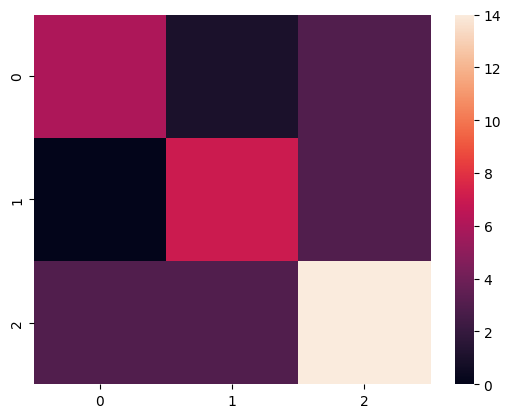

In [50]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Load
df = pd.read_csv("data_sensors.csv")

X = df.drop(columns=["Label"]).values
y = df["Label"].values  # may contain NaN

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# indices
labeled_mask = ~pd.isna(y)
unlabeled_mask = ~labeled_mask

X_lab = X_scaled[labeled_mask]
y_lab = y[labeled_mask].astype(int)

# 1) Learn label-informed embedding (fit ONLY on labeled points)
nca = NeighborhoodComponentsAnalysis(random_state=42, max_iter=1000)
nca.fit(X_lab, y_lab)

# transform ALL points
X_emb = nca.transform(X_scaled)

# 2) Choose number of clusters using BIC (GMM)
Ks = range(3, 15)  # adjust if you expect more/fewer reasons
bics = []
gmms = []
for k in Ks:
    gmm = GaussianMixture(n_components=k, covariance_type="diag", random_state=42, reg_covar=1e-6, n_init=10, max_iter=500)
    gmm.fit(X_emb)
    bics.append(gmm.bic(X_emb))
    gmms.append(gmm)

best_idx = int(np.argmin(bics))
best_k = Ks[best_idx]
best_gmm = gmms[best_idx]
print(f"Chosen K via BIC: {best_k}")

# 3) Cluster everyone
clusters = best_gmm.predict(X_emb)
df["Cluster"] = clusters

# 4) Name clusters using the 40 labels
cluster_to_reason = {}
cluster_majority_frac = {}
min_labeled_in_cluster = 3  # set higher if you want more stability

for c in sorted(df["Cluster"].unique()):
    lab_in_c = df.loc[(df["Cluster"] == c) & labeled_mask, "Label"].astype(int)
    if len(lab_in_c) < min_labeled_in_cluster:
        cluster_to_reason[c] = "UNKNOWN (few labels)"
        cluster_majority_frac[c] = np.nan
        continue

    counts = Counter(lab_in_c)
    reason, cnt = counts.most_common(1)[0]
    cluster_to_reason[c] = f"Reason_{reason}"
    cluster_majority_frac[c] = cnt / len(lab_in_c)

df["ClusterReason"] = df["Cluster"].map(cluster_to_reason)

# 5) Summary table: sizes + labeled distribution + confidence
summary = []
for c in sorted(df["Cluster"].unique()):
    total = (df["Cluster"] == c).sum()
    labeled = ((df["Cluster"] == c) & labeled_mask).sum()
    unlabeled = total - labeled

    lab_vals = df.loc[(df["Cluster"] == c) & labeled_mask, "Label"].astype(int).tolist()
    dist = dict(Counter(lab_vals))  # counts per reason among labeled points in this cluster

    summary.append({
        "Cluster": c,
        "TotalPoints": total,
        "LabeledPoints": labeled,
        "UnlabeledPoints": unlabeled,
        "AssignedReason": cluster_to_reason[c],
        "MajorityFrac": cluster_majority_frac[c],
        "LabelDist(labeled_only)": dist
    })

summary_df = pd.DataFrame(summary).sort_values(["TotalPoints"], ascending=False)
print(summary_df.to_string(index=False))

# Optional: how well do clusters align with the 40 labeled points?
# Predict reason by cluster majority and compare on labeled subset
pred_reason = df.loc[labeled_mask, "Cluster"].map(cluster_to_reason)
# convert "Reason_x" back to int where possible
pred_int = pred_reason.str.replace("Reason_", "", regex=False)
pred_int = pd.to_numeric(pred_int, errors="coerce")

print("\nLabeled subset performance of cluster->reason mapping (ignores UNKNOWN):")
valid = ~pred_int.isna()
print(classification_report(y_lab[valid.values], pred_int[valid].astype(int), zero_division=0))
print(confusion_matrix(y_lab[valid.values], pred_int[valid].astype(int)))

In [10]:
proba = best_gmm.predict_proba(X_emb)
df["Cluster"] = proba.argmax(axis=1)
df["ClusterConfidence"] = proba.max(axis=1)

# e.g., cases to review next:
to_review = df.sort_values("ClusterConfidence").head(30)
to_review

,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Label,Cluster,ClusterReason,ClusterConfidence
1209,-0.214438,-0.064295,0.289034,0.418883,0.748111,-0.899962,0.566167,0.809036,0.378426,0.996836,...,-0.230101,0.296533,-0.996425,-0.097306,0.471973,-0.031668,NaN,3,Reason_2,0.269432
918,-0.406748,0.727447,0.443615,-0.578877,-0.626455,0.274022,0.178107,-0.771046,-0.000890,0.913861,...,-0.191405,-0.199971,0.308199,-0.182504,-0.586678,0.614380,NaN,0,Reason_2,0.320430
1454,0.295415,0.028387,0.100691,-0.011248,0.454384,0.690614,-0.000261,0.233069,0.786809,0.771389,...,-0.238493,0.592085,-0.151468,0.026101,0.122836,-0.184996,NaN,3,Reason_2,0.339992
1059,-0.738519,0.698390,-0.271618,0.265904,-0.200615,0.914215,0.322804,-0.818755,-0.401707,-0.677453,...,0.680188,0.169261,-0.232816,0.140696,0.865049,0.967298,NaN,2,Reason_3,0.340894
437,-0.056293,-0.813541,0.408239,-0.306141,0.825980,0.878651,-0.821220,-0.030387,-0.754404,-0.707283,...,-0.297769,-0.080118,-0.155347,0.106744,-0.264529,-0.140196,NaN,5,Reason_3,0.361082
853,-0.429701,0.603946,-0.126004,-0.073479,-0.649259,0.379206,0.011650,0.152963,-0.665608,-0.463735,...,0.709798,-0.085224,-0.304928,-0.546480,0.430092,-0.816231,NaN,0,Reason_2,0.363156
1198,-0.606895,0.784837,0.261598,0.894691,-0.440016,0.007483,0.083869,0.092424,-0.258674,0.706672,...,0.356773,-0.984483,-0.442000,-0.157177,-0.613832,0.797617,NaN,0,Reason_2,0.367653
39,-0.696350,0.970011,-0.193384,0.192105,0.415144,-0.064122,-0.615750,0.408859,-0.014647,0.580570,...,-0.572855,-0.709484,-0.599788,0.800787,0.966918,0.862744,NaN,0,Reason_2,0.368763
1111,0.983989,-0.068348,-0.265987,0.305791,0.407553,-0.542459,-0.483095,-0.204331,0.105794,0.474620,...,0.649845,-0.150051,0.860849,0.022048,0.247680,0.408754,NaN,0,Reason_2,0.369346
1475,0.364514,0.563883,0.417999,0.732444,-0.138328,0.369439,0.581043,-0.431603,-0.141838,0.162102,...,0.968587,0.990628,0.827319,0.260817,-0.714703,0.163618,NaN,2,Reason_3,0.369840


In [4]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from collections import Counter

# ------------------------
# Config
# ------------------------
DATA_PATH = "data_sensors.csv"
K_RANGE = range(3, 15)          # BIC search range
GMM_COV = "diag"                # stable & fast
GMM_REG = 1e-6                  # stabilizer
GMM_N_INIT = 10                 # robustness to local optima
GMM_MAX_ITER = 500
MIN_LABELED_IN_CLUSTER = 2      # threshold for naming
RANDOM_STATE = 42

# ------------------------
# Load + scale
# ------------------------
df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c != "Label"]

X = df[feature_cols].values
y_raw = df["Label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

labeled_mask = ~pd.isna(y_raw)
labeled_idx = np.where(labeled_mask)[0]
y_lab = df.loc[labeled_mask, "Label"].astype(int).values

print("Total points:", len(df))
print("Labeled points:", labeled_mask.sum())
print("Unlabeled points:", (~labeled_mask).sum())
print("Label counts:\n", df["Label"].value_counts(dropna=False))

# ------------------------
# 1) NCA embedding (fit ONLY on labeled)
# ------------------------
nca = NeighborhoodComponentsAnalysis(random_state=RANDOM_STATE, max_iter=1000)
nca.fit(X_scaled[labeled_mask], y_lab)
X_emb = nca.transform(X_scaled)

# ------------------------
# 2) Choose K via BIC (GMM)
# ------------------------
bics, gmms = [], []
for k in K_RANGE:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=GMM_COV,
        reg_covar=GMM_REG,
        n_init=GMM_N_INIT,
        max_iter=GMM_MAX_ITER,
        random_state=RANDOM_STATE,
    )
    gmm.fit(X_emb)
    bics.append(gmm.bic(X_emb))
    gmms.append(gmm)

best_idx = int(np.argmin(bics))
best_k = list(K_RANGE)[best_idx]
best_gmm = gmms[best_idx]
print(f"\nChosen K via BIC: {best_k}")

# ------------------------
# 3) Cluster everyone + cluster confidence
# ------------------------
cluster_proba = best_gmm.predict_proba(X_emb)
df["Cluster"] = cluster_proba.argmax(axis=1)
df["ClusterConfidence"] = cluster_proba.max(axis=1)

# ------------------------
# 4) Name clusters with labeled points + compute purity
# ------------------------
cluster_to_reason = {}
cluster_purity = {}
cluster_label_dist = {}

for c in sorted(df["Cluster"].unique()):
    lab_in_c = df.loc[(df["Cluster"] == c) & labeled_mask, "Label"].astype(int).tolist()
    counts = Counter(lab_in_c)
    cluster_label_dist[c] = dict(counts)

    if len(lab_in_c) < MIN_LABELED_IN_CLUSTER:
        cluster_to_reason[c] = "UNKNOWN (few labels)"
        cluster_purity[c] = np.nan
        continue

    reason, cnt = counts.most_common(1)[0]
    cluster_to_reason[c] = f"Reason_{reason}"
    cluster_purity[c] = cnt / len(lab_in_c)

df["ClusterReason"] = df["Cluster"].map(cluster_to_reason)
df["ClusterPurityLabeled"] = df["Cluster"].map(cluster_purity)

# ------------------------
# 5) Summary table
# ------------------------
summary_rows = []
for c in sorted(df["Cluster"].unique()):
    total = int((df["Cluster"] == c).sum())
    labeled = int(((df["Cluster"] == c) & labeled_mask).sum())
    unlabeled = total - labeled

    summary_rows.append({
        "Cluster": c,
        "TotalPoints": total,
        "LabeledPoints": labeled,
        "UnlabeledPoints": unlabeled,
        "AssignedReason": cluster_to_reason[c],
        "PurityOnLabeled": cluster_purity[c],
        "LabelDist(labeled_only)": cluster_label_dist[c]
    })

summary_df = pd.DataFrame(summary_rows).sort_values("TotalPoints", ascending=False)
print("\nCluster summary (core deliverable):")
print(summary_df.to_string(index=False))



Total points: 1600
Labeled points: 40
Unlabeled points: 1560
Label counts:
 Label
NaN    1560
3.0      20
2.0      10
1.0      10
Name: count, dtype: int64

Chosen K via BIC: 7

Cluster summary (core deliverable):
 Cluster  TotalPoints  LabeledPoints  UnlabeledPoints AssignedReason  PurityOnLabeled LabelDist(labeled_only)
       6          295              5              290       Reason_3         0.600000      {3: 3, 2: 1, 1: 1}
       3          238              6              232       Reason_2         0.666667      {2: 4, 1: 1, 3: 1}
       0          229              5              224       Reason_2         0.600000            {3: 2, 2: 3}
       1          222              5              217       Reason_3         0.600000            {3: 3, 1: 2}
       5          216              5              211       Reason_3         0.600000            {2: 2, 3: 3}
       2          202              5              197       Reason_3         1.000000                  {3: 5}
       4        

In [5]:
# ------------------------
# 6) Optional: per-cluster sensor profile (top sensors driving each cluster)
#    (difference of means: cluster mean - global mean, in scaled units)
# ------------------------
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
global_mean = X_scaled_df.mean(axis=0)

profiles = []
TOP_N_SENSORS = 5

for c in sorted(df["Cluster"].unique()):
    idx = df["Cluster"] == c
    cluster_mean = X_scaled_df.loc[idx].mean(axis=0)
    delta = (cluster_mean - global_mean).sort_values(key=lambda s: s.abs(), ascending=False)

    top = delta.head(TOP_N_SENSORS)
    profiles.append({
        "Cluster": c,
        "AssignedReason": cluster_to_reason[c],
        "TopSensors(delta_from_global_mean)": ", ".join([f"{name}({val:+.2f})" for name, val in top.items()])
    })

profiles_df = pd.DataFrame(profiles).sort_values("Cluster")
print("\nPer-cluster sensor signature (top drivers):")
print(profiles_df.to_string(index=False))

# ------------------------
# Save enriched dataset if you want
# ------------------------
df.to_csv("data_sensors_with_clusters.csv", index=False)
print("\nSaved: data_sensors_with_clusters.csv")



Per-cluster sensor signature (top drivers):
 Cluster AssignedReason                                                     TopSensors(delta_from_global_mean)
       0       Reason_2  Sensor 0(+0.66), Sensor 13(+0.61), Sensor 10(-0.60), Sensor 2(+0.56), Sensor 8(-0.37)
       1       Reason_3 Sensor 16(+0.89), Sensor 14(-0.65), Sensor 2(-0.45), Sensor 15(+0.42), Sensor 5(-0.39)
       2       Reason_3  Sensor 13(-0.79), Sensor 0(-0.76), Sensor 10(+0.58), Sensor 2(-0.47), Sensor 5(-0.41)
       3       Reason_2  Sensor 19(-0.84), Sensor 10(+0.53), Sensor 9(-0.51), Sensor 7(+0.40), Sensor 2(+0.35)
       4       Reason_1  Sensor 1(-0.83), Sensor 9(+0.79), Sensor 5(+0.56), Sensor 15(-0.50), Sensor 19(+0.45)
       5       Reason_3  Sensor 17(-0.80), Sensor 7(-0.71), Sensor 8(-0.50), Sensor 0(+0.48), Sensor 16(-0.47)
       6       Reason_3  Sensor 8(+0.66), Sensor 11(+0.62), Sensor 6(-0.62), Sensor 14(+0.45), Sensor 1(+0.35)

Saved: data_sensors_with_clusters.csv


In [6]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading

df = pd.read_csv("data_sensors.csv")
feature_cols = [c for c in df.columns if c != "Label"]

X = df[feature_cols].values
y_raw = df["Label"]

X_scaled = StandardScaler().fit_transform(X)

# Semi-supervised labels: unlabeled = -1
y_semi = y_raw.fillna(-1).astype(int).values

# KNN graph tends to be more stable than RBF here
ls = LabelSpreading(kernel="knn", n_neighbors=25, alpha=0.2, max_iter=200)
ls.fit(X_scaled, y_semi)

proba = ls.predict_proba(X_scaled)
pred = proba.argmax(axis=1)
conf = proba.max(axis=1)

df_triage = df.copy()
df_triage["LS_PredLabel"] = pred
df_triage["LS_Confidence"] = conf

unlabeled_mask = df["Label"].isna()

# 30 lowest-confidence unlabeled points => highest value to label next
to_label_next = df_triage.loc[unlabeled_mask].sort_values("LS_Confidence").head(30)

print("\nTop 30 unlabeled points to label next (lowest LS confidence):")
print(to_label_next[["LS_PredLabel", "LS_Confidence"]])

# Optional summary
summary = (
    df_triage.loc[unlabeled_mask]
    .groupby("LS_PredLabel")
    .agg(UnlabeledCount=("LS_PredLabel", "size"),
         MeanConfidence=("LS_Confidence", "mean"),
         MedianConfidence=("LS_Confidence", "median"))
    .sort_values("UnlabeledCount", ascending=False)
)
print("\nLabelSpreading triage summary (unlabeled only):")
print(summary)



Top 30 unlabeled points to label next (lowest LS confidence):
      LS_PredLabel  LS_Confidence
1131             1       0.338885
1362             1       0.340724
605              1       0.341069
944              1       0.342146
16               1       0.342973
1445             1       0.344639
1520             0       0.345245
1033             2       0.345589
225              2       0.347078
53               0       0.347678
604              1       0.349460
579              0       0.350112
237              1       0.350250
1126             0       0.351111
312              0       0.351692
1144             1       0.351989
1356             1       0.352862
354              2       0.352927
495              0       0.353298
1082             2       0.353361
1227             2       0.353479
12               2       0.354056
780              1       0.354080
403              1       0.354564
1336             0       0.355356
359              1       0.355801
561              1 

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from collections import Counter

# 1. Load and Scale
df = pd.read_csv("data_sensors.csv")
X = df.drop(columns=["Label"]).values
y = df["Label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

labeled_mask = ~pd.isna(y)
X_lab = X_scaled[labeled_mask]
y_lab = y[labeled_mask].astype(int)

# 2. NCA Embedding (Fit ONLY on 40 labels)
nca = NeighborhoodComponentsAnalysis(random_state=42, max_iter=1000)
nca.fit(X_lab, y_lab)
X_emb = nca.transform(X_scaled)

K_RANGE = range(3, 15)
bics, gmms = [], []
for k in K_RANGE:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=GMM_COV,
        reg_covar=GMM_REG,
        n_init=GMM_N_INIT,
        max_iter=GMM_MAX_ITER,
        random_state=RANDOM_STATE,
    )
    gmm.fit(X_emb)
    bics.append(gmm.bic(X_emb))
    gmms.append(gmm)

best_idx = int(np.argmin(bics))
best_k = list(K_RANGE)[best_idx]
best_gmm = gmms[best_idx]
print(f"\nChosen K via BIC: {best_k}")

# 3. GMM Clustering (Using K=7 and Diag covariance as previously determined)
df["Cluster"] = best_gmm.fit_predict(X_emb)

# 4. Calculate Probabilistic Mapping
cluster_probs = {}

for c in range(best_k):
    # Get labels existing in this specific cluster
    labels_in_cluster = df.loc[(df["Cluster"] == c) & labeled_mask, "Label"].astype(int)

    if len(labels_in_cluster) == 0:
        cluster_probs[c] = "No labeled data (Unknown)"
        continue

    # Calculate percentages
    counts = Counter(labels_in_cluster)
    total = len(labels_in_cluster)

    # Sort by highest probability first
    prob_strings = []
    for reason, count in counts.most_common():
        prob = (count / total) * 100
        prob_strings.append(f"{prob:.1f}% Reason {reason}")

    cluster_probs[c] = ", ".join(prob_strings)

# 5. Apply to Data
df["ReasonProbability"] = df["Cluster"].map(cluster_probs)

# 6. Generate Summary Table
summary_data = []
for c in range(best_k):
    cluster_df = df[df["Cluster"] == c]
    labeled_count = cluster_df["Label"].notna().sum()
    unlabeled_count = cluster_df["Label"].isna().sum()

    summary_data.append({
        "Cluster": c,
        "Unlabeled_Points": unlabeled_count,
        "Labeled_Points": labeled_count,
        "Probabilistic_Reason": cluster_probs[c],
        "Certainty": "High" if "100.0%" in cluster_probs[c] else "Ambiguous"
    })

summary_df = pd.DataFrame(summary_data).sort_values("Unlabeled_Points", ascending=False)

print("\n--- Probabilistic Cluster Assignment Summary ---")
print(summary_df.to_string(index=False))


Chosen K via BIC: 7

--- Probabilistic Cluster Assignment Summary ---
 Cluster  Unlabeled_Points  Labeled_Points                           Probabilistic_Reason Certainty
       6               290               5 60.0% Reason 3, 20.0% Reason 2, 20.0% Reason 1 Ambiguous
       3               232               6 66.7% Reason 2, 16.7% Reason 1, 16.7% Reason 3 Ambiguous
       0               224               5                 60.0% Reason 2, 40.0% Reason 3 Ambiguous
       1               217               5                 60.0% Reason 3, 40.0% Reason 1 Ambiguous
       5               211               5                 60.0% Reason 3, 40.0% Reason 2 Ambiguous
       2               197               5                                100.0% Reason 3      High
       4               189               9                 66.7% Reason 1, 33.3% Reason 3 Ambiguous


In [14]:
# Show a sample of predicted unlabeled rows
print("\n--- Sample Predictions for Unlabeled Sensors ---")
df.loc[~labeled_mask, ["Cluster", "ReasonProbability"]].head(10)


--- Sample Predictions for Unlabeled Sensors ---


,Cluster,ReasonProbability
0,3,"66.7% Reason 2, 16.7% Reason 1, 16.7% Reason 3"
1,1,"60.0% Reason 3, 40.0% Reason 1"
2,5,"60.0% Reason 3, 40.0% Reason 2"
3,0,"60.0% Reason 2, 40.0% Reason 3"
4,0,"60.0% Reason 2, 40.0% Reason 3"
5,1,"60.0% Reason 3, 40.0% Reason 1"
7,3,"66.7% Reason 2, 16.7% Reason 1, 16.7% Reason 3"
8,3,"66.7% Reason 2, 16.7% Reason 1, 16.7% Reason 3"
9,1,"60.0% Reason 3, 40.0% Reason 1"
10,3,"66.7% Reason 2, 16.7% Reason 1, 16.7% Reason 3"


### LS LP

In [31]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# Load
df = pd.read_csv("data_sensors.csv")
X = df.drop(columns=["Label"]).values
y_raw = df["Label"].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Labeled info
labeled_mask = ~pd.isna(y_raw)
labeled_idx = np.where(labeled_mask)[0]
y_lab = y_raw[labeled_mask].astype(int)
classes = np.unique(y_lab)

# ---- Fit NCA on labeled only ----
nca = NeighborhoodComponentsAnalysis(random_state=42, max_iter=1000)
nca.fit(X_scaled[labeled_mask], y_lab)
X_emb = nca.transform(X_scaled)

# ---- CV evaluation in embedding space ----
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, y_true_all, y_pred_all = [], [], []

for tr_local, te_local in skf.split(np.zeros(len(y_lab)), y_lab):
    tr_idx = labeled_idx[tr_local]
    te_idx = labeled_idx[te_local]

    y_semi = np.full(X.shape[0], -1, dtype=int)
    y_semi[tr_idx] = y_lab[tr_local]

    ls = LabelSpreading(kernel="knn", n_neighbors=25, alpha=0.2, max_iter=200)
    ls.fit(X_emb, y_semi)

    y_pred = ls.predict(X_emb[te_idx])
    y_true = y_lab[te_local]

    accs.append(accuracy_score(y_true, y_pred))
    y_true_all.append(y_true)
    y_pred_all.append(y_pred)

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

print(f"\nNCA + LabelSpreading(knn=25) CV accuracy: mean={np.mean(accs):.4f}, std={np.std(accs, ddof=1):.4f}")
print(classification_report(y_true_all, y_pred_all, labels=classes, zero_division=0))

# ---- Train on all 40 labels, predict the 1560 ----
y_semi_full = df["Label"].fillna(-1).astype(int).values

ls_full = LabelSpreading(kernel="knn", n_neighbors=25, alpha=0.2, max_iter=200)
ls_full.fit(X_emb, y_semi_full)

pred_all = ls_full.predict(X_emb)
proba = ls_full.predict_proba(X_emb)
conf = proba.max(axis=1)

df_out = df.copy()
df_out["PredLabel"] = pred_all
df_out["Confidence"] = conf

# Summary for unlabeled
unlabeled_mask = df["Label"].isna()
summary = (
    df_out.loc[unlabeled_mask]
          .groupby("PredLabel")
          .agg(UnlabeledCount=("PredLabel", "size"),
               MeanConfidence=("Confidence", "mean"),
               MedianConfidence=("Confidence", "median"))
          .sort_values("UnlabeledCount", ascending=False)
)
print("\nUnlabeled assignment summary (NCA+LS):")
print(summary)



NCA + LabelSpreading(knn=25) CV accuracy: mean=0.9000, std=0.1046
              precision    recall  f1-score   support

           1       1.00      0.90      0.95        10
           2       0.82      0.90      0.86        10
           3       0.90      0.90      0.90        20

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40


Unlabeled assignment summary (NCA+LS):
           UnlabeledCount  MeanConfidence  MedianConfidence
PredLabel                                                  
3                     619        0.565100          0.550419
2                     476        0.570150          0.557436
1                     465        0.577045          0.560362


In [6]:
# Low-confidence review list (great for expert labeling next)
review = df_out.loc[unlabeled_mask].sort_values("Confidence").head(30)
print("\n30 unlabeled points to review next (lowest confidence):")
review


30 unlabeled points to review next (lowest confidence):


,Sensor 0,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Label,PredLabel,Confidence
819,-0.136688,0.469889,0.500194,0.223009,-0.561702,-0.851407,-0.950707,0.681378,-0.848293,0.044680,...,0.624344,-0.145611,0.086730,-0.198402,0.352035,-0.193744,-0.719189,NaN,3,0.337008
254,-0.388667,-0.237213,-0.412813,-0.717665,-0.990251,-0.262134,0.168242,-0.719916,0.766602,-0.867902,...,0.258828,-0.783492,-0.704390,0.639823,-0.575521,0.935738,-0.639430,NaN,2,0.345753
804,0.515463,-0.393733,-0.089875,-0.186338,0.669473,0.148224,0.056127,-0.755930,-0.267894,0.481841,...,0.259580,0.849187,-0.625399,-0.420305,-0.399865,-0.267821,-0.499990,NaN,2,0.345957
913,-0.683695,0.018329,-0.183559,0.702945,-0.112778,0.089807,-0.766080,-0.411532,-0.079171,0.517090,...,0.264405,0.632229,0.529001,-0.531861,-0.509128,0.186362,-0.851670,NaN,2,0.346294
555,-0.180754,-0.831398,0.449667,0.239663,-0.221026,-0.073559,-0.472717,-0.176904,-0.968146,0.217236,...,-0.661664,0.843435,0.831236,-0.359864,-0.744574,-0.128099,-0.982049,NaN,3,0.350103
711,0.463080,-0.624048,-0.080982,-0.091880,-0.855739,-0.040775,0.482757,0.489135,0.718497,-0.381489,...,-0.275682,-0.237750,-0.824781,0.248806,-0.014472,0.784875,0.652241,NaN,1,0.350778
818,0.134768,-0.569135,-0.109152,0.309314,0.782477,-0.915370,-0.982053,-0.028821,0.289143,0.739676,...,0.359304,-0.613449,-0.782430,-0.769159,0.838459,-0.600882,-0.950939,NaN,2,0.351783
1563,-0.854569,0.716087,0.169738,0.391518,-0.823123,0.213276,-0.481980,0.339281,-0.969937,-0.797780,...,0.394919,-0.197927,-0.658599,-0.461833,-0.288994,0.770092,0.470935,NaN,3,0.353596
1217,-0.277560,-0.896806,-0.136433,-0.241861,0.276733,0.979280,0.429123,0.007213,-0.789034,-0.546760,...,0.320665,0.201694,0.517478,-0.490397,-0.632351,-0.779728,0.397638,NaN,3,0.354220
1541,0.540429,0.286012,0.360496,0.407428,-0.791342,-0.670728,0.295910,0.429029,-0.435001,0.470594,...,-0.445887,-0.701383,0.166542,-0.437507,-0.515802,-0.475918,-0.443733,NaN,3,0.356219


### NCA + GMM

   Reason  Label Spreading Count  NCA + GMM Count
0     1.0                    629              782
1     2.0                    340              345
2     3.0                    631              473

Cluster to Label Mapping: {0: np.float64(2.0), 1: np.float64(1.0), 2: np.float64(3.0)}


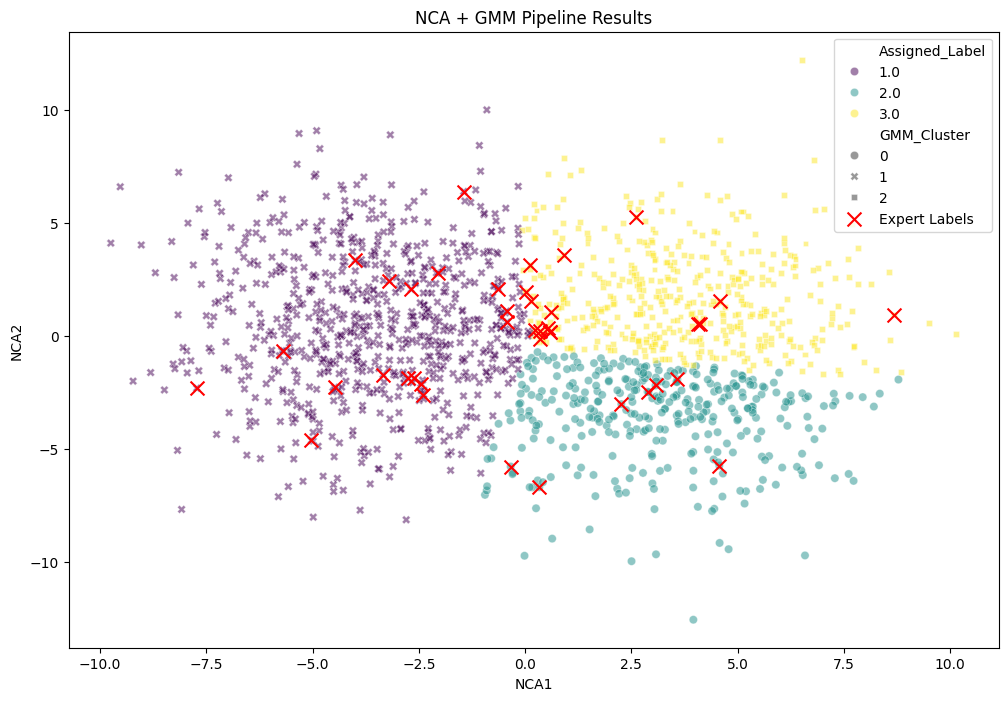

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from scipy.stats import mode

# Load data
df = pd.read_csv('data_sensors (1).csv')
X = df.drop(columns=['Label'])
y = df['Label']

# 1. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. NCA (Neighborhood Components Analysis)
# We can only fit NCA on the labeled data
labeled_mask = y.notna()
X_labeled = X_scaled[labeled_mask]
y_labeled = y[labeled_mask]

nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
nca.fit(X_labeled, y_labeled)
X_nca = nca.transform(X_scaled)

# 3. GMM (Gaussian Mixture Model)
# We cluster all 1600 points in the NCA-transformed space
gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(X_nca)

# 4. Map Clusters to Labels
# For each cluster, find the most frequent expert label
cluster_to_label = {}
for i in range(3):
    mask = (clusters == i) & labeled_mask
    if mask.any():
        # Get labels of expert points in this cluster
        labels_in_cluster = y[mask]
        most_common_label = mode(labels_in_cluster, keepdims=True).mode[0]
        cluster_to_label[i] = most_common_label
    else:
        cluster_to_label[i] = -1 # Or handle appropriately

# Apply mapping
nca_gmm_labels = [cluster_to_label[c] for c in clusters]

# Visualization
plt.figure(figsize=(12, 8))
plot_df = pd.DataFrame(X_nca, columns=['NCA1', 'NCA2'])
plot_df['GMM_Cluster'] = clusters
plot_df['Assigned_Label'] = nca_gmm_labels
plot_df['Original_Label'] = y

sns.scatterplot(data=plot_df, x='NCA1', y='NCA2', hue='Assigned_Label',
                palette='viridis', style='GMM_Cluster', alpha=0.5)
plt.scatter(X_nca[labeled_mask, 0], X_nca[labeled_mask, 1],
            c='red', marker='x', s=100, label='Expert Labels')
plt.title('NCA + GMM Pipeline Results')
plt.legend()
plt.savefig('nca_gmm_comparison.png')

# Summary
ls_counts = [629, 340, 631] # From previous run
nca_gmm_counts = pd.Series(nca_gmm_labels).value_counts().sort_index()

comparison = pd.DataFrame({
    'Reason': [1.0, 2.0, 3.0],
    'Label Spreading Count': ls_counts,
    'NCA + GMM Count': [nca_gmm_counts.get(1.0, 0), nca_gmm_counts.get(2.0, 0), nca_gmm_counts.get(3.0, 0)]
})

# Export
df['NCA_GMM_Label'] = nca_gmm_labels
df.to_csv('nca_gmm_results.csv', index=False)

print(comparison)
print("\nCluster to Label Mapping:", cluster_to_label)

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, classification_report

# Load data
df = pd.read_csv('data_sensors (1).csv')
X = df.drop(columns=['Label'])
y = df['Label']

# Filter labeled data for CV
labeled_mask = y.notna()
X_labeled = X[labeled_mask]
y_labeled = y[labeled_mask]

# 1. Internal Metric: Silhouette Score
# We use the NCA + GMM result from the previous step
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Refit NCA on all labeled data to get the space
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
nca.fit(scaler.transform(X_labeled), y_labeled)
X_nca = nca.transform(X_scaled)

# Fit GMM
gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(X_nca)

sil_score = silhouette_score(X_nca, clusters)

# 2. External Metric: Cross-Validation on Labeled Data
# We test if the NCA dimensionality reduction actually helps a classifier (proxy for GMM success)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

# Pipeline: Scale -> NCA -> KNN (as a proxy for the GMM mapping logic)
for train_idx, test_idx in skf.split(X_labeled, y_labeled):
    X_train_cv, X_test_cv = X_labeled.iloc[train_idx], X_labeled.iloc[test_idx]
    y_train_cv, y_test_cv = y_labeled.iloc[train_idx], y_labeled.iloc[test_idx]

    # Scale based on training
    cv_scaler = StandardScaler()
    X_train_sc = cv_scaler.fit_transform(X_train_cv)
    X_test_sc = cv_scaler.transform(X_test_cv)

    # Fit NCA
    cv_nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)
    cv_nca.fit(X_train_sc, y_train_cv)

    # Transform
    X_train_nca = cv_nca.transform(X_train_sc)
    X_test_nca = cv_nca.transform(X_test_sc)

    # Simple Classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_nca, y_train_cv)
    cv_scores.append(knn.score(X_test_nca, y_test_cv))

mean_cv = np.mean(cv_scores)

print(f"Silhouette Score (NCA Space): {sil_score:.4f}")
print(f"Cross-Validation Accuracy (on 40 labels): {mean_cv:.4f}")

Silhouette Score (NCA Space): 0.0433
Cross-Validation Accuracy (on 40 labels): 0.3500


Average GMM Confidence: 0.9404
Mapping Accuracy (on 40 labels): 0.7250
Correlation of Sensor 9 with Predicted Labels: -0.6457


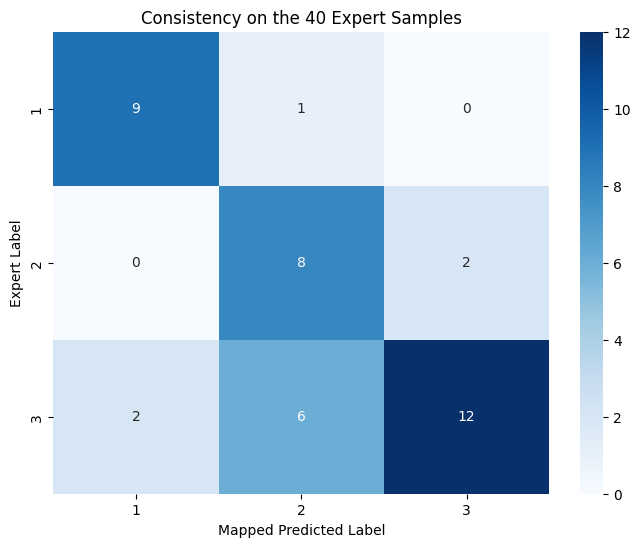

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. GMM Probabilities (Confidence)
probs = gmm.predict_proba(X_nca)
max_probs = np.max(probs, axis=1)
avg_confidence = np.mean(max_probs)

# 2. Cluster Purity / Mapping Accuracy for the 40 points
# Find which cluster each of the 40 points fell into
labeled_indices = np.where(labeled_mask)[0]
actual_labels = y.iloc[labeled_indices].values
predicted_clusters = clusters[labeled_indices]

# Map cluster IDs back to labels based on the mapping we established earlier
# Mapping: {0: 2.0, 1: 1.0, 2: 3.0}
mapping = {0: 2.0, 1: 1.0, 2: 3.0}
mapped_predictions = np.array([mapping[c] for c in predicted_clusters])

mapping_accuracy = np.mean(mapped_predictions == actual_labels)

# 3. Correlation with Important Sensors
# Let's see if the predicted labels correlate with Sensor 9
df['Predicted_Label'] = [mapping[c] for c in clusters]
sensor_9_corr = df[['Sensor 9', 'Predicted_Label']].corr().iloc[0, 1]

print(f"Average GMM Confidence: {avg_confidence:.4f}")
print(f"Mapping Accuracy (on 40 labels): {mapping_accuracy:.4f}")
print(f"Correlation of Sensor 9 with Predicted Labels: {sensor_9_corr:.4f}")

# Plot confusion matrix for the 40 points
cm = confusion_matrix(actual_labels, mapped_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[1,2,3], yticklabels=[1,2,3], cmap='Blues')
plt.xlabel('Mapped Predicted Label')
plt.ylabel('Expert Label')
plt.title('Consistency on the 40 Expert Samples')
plt.savefig('evaluation_cm.png')

## Decision Tree

In [19]:
# Check indices of labeled data
labeled_indices = df.index[df['Label'].notna()].tolist()
print(f"Labeled indices: {labeled_indices}")

# Test a simple Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut

dt = DecisionTreeClassifier(max_depth=7, random_state=42)
loo = LeaveOneOut()
loo_scores = []

for train_ix, test_ix in loo.split(X_labeled):
    X_tr, X_te = X_labeled.iloc[train_ix], X_labeled.iloc[test_ix]
    y_tr, y_te = y_labeled.iloc[train_ix], y_labeled.iloc[test_ix]
    dt.fit(X_tr, y_tr)
    loo_scores.append(dt.score(X_te, y_te))

print(f"Decision Tree LOO Accuracy: {np.mean(loo_scores):.4f}")

# Look at the tree's chosen features
dt.fit(X_labeled, y_labeled)
important_idx = np.argsort(dt.feature_importances_)[-3:]
print(f"DT Top Features: {X.columns[important_idx].tolist()}")

Labeled indices: [6, 22, 81, 89, 231, 304, 319, 366, 390, 418, 477, 528, 539, 545, 556, 572, 675, 694, 709, 741, 758, 937, 938, 958, 960, 975, 977, 1086, 1103, 1176, 1266, 1338, 1345, 1415, 1490, 1498, 1535, 1569, 1574, 1597]
Decision Tree LOO Accuracy: 0.9000
DT Top Features: ['Sensor 2', 'Sensor 13', 'Sensor 9']


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=700, random_state=42)
rf_cv_scores = cross_val_score(rf, X_labeled, y_labeled, cv=5)
print(f"Random Forest 5-Fold CV Accuracy: {np.mean(rf_cv_scores):.4f}")

# Train and predict on all
rf.fit(X_labeled, y_labeled)
final_predictions = rf.predict(X)

# Update stats
final_counts = pd.Series(final_predictions).value_counts().sort_index()
print(f"Final Grouping (RF):\n{final_counts}")

Random Forest 5-Fold CV Accuracy: 0.6250
Final Grouping (RF):
1.0    563
2.0    448
3.0    589
Name: count, dtype: int64


In [26]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Load data
paths = ["data_sensors (1).csv", "data_sensors.csv"]
df = None
for p in paths:
    try:
        df = pd.read_csv(p)
        path = p
        break
    except FileNotFoundError:
        pass
if df is None:
    raise FileNotFoundError("Could not find data_sensors csv")

sensor_cols = [c for c in df.columns if c.startswith("Sensor")]
label_col = "Label"

mask = df[label_col].notna()
df_lab = df.loc[mask].copy()
X = df_lab[sensor_cols].to_numpy()
y = df_lab[label_col].astype(float).to_numpy()
uniq = np.array(sorted(np.unique(y)))

print("=== Labeled subset ===")
print("File:", path)
print("X shape:", X.shape)
vals, cnts = np.unique(y, return_counts=True)
print("Class counts:", dict(zip(vals, cnts)))

# RF model (reasonable baseline)
rf = RandomForestClassifier(
    n_estimators=800,
    min_samples_leaf=2,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

# -------------------------------
# 1) Repeated Stratified CV
# -------------------------------
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=50, random_state=42)

accs, f1s = [], []
cm_sum = np.zeros((len(uniq), len(uniq)), dtype=int)

for tr, te in rskf.split(X, y):
    rf.fit(X[tr], y[tr])
    pred = rf.predict(X[te])
    accs.append(accuracy_score(y[te], pred))
    f1s.append(f1_score(y[te], pred, average="macro"))
    cm_sum += confusion_matrix(y[te], pred, labels=uniq)

print("\n=== RandomForest: RepeatedStratifiedKFold (5x50=250 folds) ===")
print(f"Accuracy: mean={np.mean(accs):.4f}, std={np.std(accs):.4f}")
print(f"Macro-F1: mean={np.mean(f1s):.4f}, std={np.std(f1s):.4f}")

print("\n=== Aggregated confusion matrix (sum over all folds) ===")
cm_df = pd.DataFrame(cm_sum, index=[f"true_{int(l)}" for l in uniq], columns=[f"pred_{int(l)}" for l in uniq])
print(cm_df.to_string())

# Approx per-class precision/recall from aggregated CM
cm = cm_sum.astype(float)
recall = np.diag(cm) / cm.sum(axis=1)
precision = np.diag(cm) / np.maximum(cm.sum(axis=0), 1e-9)
print("\nApprox per-class recall:", {int(lab): float(r) for lab, r in zip(uniq, recall)})
print("Approx per-class precision:", {int(lab): float(p) for lab, p in zip(uniq, precision)})

# -------------------------------
# 2) Permutation test
# -------------------------------
cv_perm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# observed
obs_accs = []
for tr, te in cv_perm.split(X, y):
    rf.fit(X[tr], y[tr])
    pred = rf.predict(X[te])
    obs_accs.append(accuracy_score(y[te], pred))
obs_acc = float(np.mean(obs_accs))

n_perm = 500
perm_scores = np.zeros(n_perm, dtype=float)
rng = np.random.default_rng(42)

for i in range(n_perm):
    y_perm = y.copy()
    rng.shuffle(y_perm)
    fold_accs = []
    for tr, te in cv_perm.split(X, y_perm):
        rf.fit(X[tr], y_perm[tr])
        pred = rf.predict(X[te])
        fold_accs.append(accuracy_score(y_perm[te], pred))
    perm_scores[i] = np.mean(fold_accs)

p_value = (np.sum(perm_scores >= obs_acc) + 1) / (n_perm + 1)

print("\n=== RandomForest: Permutation test (500 shuffles; 5-fold stratified CV) ===")
print(f"Observed mean CV accuracy (same scheme): {obs_acc:.4f}")
print(f"Permuted accuracies: mean={perm_scores.mean():.4f}, std={perm_scores.std():.4f}, max={perm_scores.max():.4f}")
print(f"Empirical p-value (perm >= observed): {p_value:.4f}")

# -------------------------------
# 3) Nearest-neighbor distances
# -------------------------------
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

nn = NearestNeighbors(n_neighbors=2, metric="euclidean")
nn.fit(Xz)
dists, _ = nn.kneighbors(Xz)
nearest_dist = dists[:, 1]

print("\n=== Nearest-neighbor distances (labeled, standardized features) ===")
print("min/median/90%/max =",
      float(np.min(nearest_dist)),
      float(np.median(nearest_dist)),
      float(np.quantile(nearest_dist, 0.9)),
      float(np.max(nearest_dist)))
print(f"Near-duplicates (<1e-6): {int(np.sum(nearest_dist < 1e-6))} / {len(nearest_dist)}")


=== Labeled subset ===
File: data_sensors (1).csv
X shape: (40, 20)
Class counts: {np.float64(1.0): np.int64(10), np.float64(2.0): np.int64(10), np.float64(3.0): np.int64(20)}

=== RandomForest: RepeatedStratifiedKFold (5x50=250 folds) ===
Accuracy: mean=0.6690, std=0.1425
Macro-F1: mean=0.5976, std=0.1851

=== Aggregated confusion matrix (sum over all folds) ===
        pred_1  pred_2  pred_3
true_1     319       0     181
true_2      29     192     279
true_3      63     110     827

Approx per-class recall: {1: 0.638, 2: 0.384, 3: 0.827}
Approx per-class precision: {1: 0.7761557177615572, 2: 0.6357615894039735, 3: 0.6425796425796426}


KeyboardInterrupt: 

## GMM


In [34]:
"""
GMM on Autoencoder latent space + choose k via BIC (+ extra evals)

What you get:
- Train an autoencoder on ALL 1600 points
- Embed to latent space Z
- Fit GaussianMixture for k in [k_min..k_max]
- Pick k that minimizes BIC
- Report: BIC/AIC, silhouette (hard labels), cluster sizes
- If you have 40 expert labels: report per-cluster label purity + cluster->label mapping
- Produce per-point: Cluster, PredictedLabel (from mapping), Confidence (GMM posterior)

Requirements:
pip install tensorflow scikit-learn pandas numpy
"""

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "./data_sensors (1).csv"
SENSOR_PREFIX = "Sensor"

LATENT_DIM = 8
AE_EPOCHS = 200
BATCH_SIZE = 30
SEED = 42

K_MIN = 3
K_MAX = 12

# GMM settings
COV_TYPE = "full"      # try: "full", "diag"
N_INIT = 10
REG_COVAR = 1e-6

# ----------------------------
# Load
# ----------------------------
df = pd.read_csv(CSV_PATH)
sensor_cols = [c for c in df.columns if c.startswith(SENSOR_PREFIX)]
if not sensor_cols:
    raise ValueError(f"No sensor columns found with prefix '{SENSOR_PREFIX}'")

X = df[sensor_cols].values.astype("float32")

# Labels (optional; NaN for unlabeled)
if "Label" in df.columns:
    y_raw = df["Label"].values
    labeled_mask = ~pd.isna(y_raw)
else:
    y_raw = None
    labeled_mask = np.zeros(len(df), dtype=bool)

# ----------------------------
# Scale
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype("float32")

# ----------------------------
# Autoencoder (pretrain on ALL)
# ----------------------------
tf.random.set_seed(SEED)
np.random.seed(SEED)

input_dim = X_scaled.shape[1]

inp = keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(inp)
x = layers.Dense(32, activation="relu")(x)
z = layers.Dense(LATENT_DIM, name="latent")(x)

x = layers.Dense(32, activation="relu")(z)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(input_dim, activation=None)(x)

ae = keras.Model(inp, out)
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
ae.fit(X_scaled, X_scaled, epochs=AE_EPOCHS, batch_size=BATCH_SIZE, verbose=0)

encoder = keras.Model(ae.input, ae.get_layer("latent").output)
Z = encoder.predict(X_scaled, verbose=0)

# ----------------------------
# GMM model selection by BIC
# ----------------------------
records = []
gmms = {}

for k in range(K_MIN, K_MAX + 1):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=COV_TYPE,
        n_init=N_INIT,
        reg_covar=REG_COVAR,
        random_state=SEED
    )
    gmm.fit(Z)

    bic = gmm.bic(Z)
    aic = gmm.aic(Z)

    # hard labels for silhouette; silhouette requires >1 cluster and <n_samples clusters
    labels = gmm.predict(Z)
    sil = np.nan
    if len(np.unique(labels)) > 1 and len(np.unique(labels)) < len(Z):
        sil = silhouette_score(Z, labels)

    records.append({"k": k, "bic": bic, "aic": aic, "silhouette": sil})
    gmms[k] = gmm

eval_df = pd.DataFrame(records).sort_values("k")
print("\nGMM model selection (lower BIC is better):")
print(eval_df.to_string(index=False))

best_k = int(eval_df.loc[eval_df["bic"].idxmin(), "k"])
best_gmm = gmms[best_k]
print(f"\nChosen k by BIC: {best_k}")

# ----------------------------
# Fit best model + outputs
# ----------------------------
cluster = best_gmm.predict(Z)
post = best_gmm.predict_proba(Z)              # posterior over components
confidence = post.max(axis=1).astype(float)   # max posterior

# Cluster sizes
unique, counts = np.unique(cluster, return_counts=True)
sizes = dict(zip(unique.tolist(), counts.tolist()))
print("\nCluster sizes:", sizes)

# ----------------------------
# If labeled points exist: cluster->label mapping + purity
# ----------------------------
cluster_to_label = {}
cluster_purity = {}

if y_raw is not None and labeled_mask.sum() > 0:
    y_lab = y_raw[labeled_mask].astype(int)
    cl_lab = cluster[labeled_mask]

    for c in range(best_k):
        idx = np.where(cl_lab == c)[0]
        if len(idx) == 0:
            cluster_to_label[c] = None
            cluster_purity[c] = 0.0
            continue

        labels_here = y_lab[idx]
        vals, cnts = np.unique(labels_here, return_counts=True)
        maj_label = int(vals[np.argmax(cnts)])
        purity = float(cnts.max() / cnts.sum())

        cluster_to_label[c] = maj_label
        cluster_purity[c] = purity

    print("\nCluster->Label mapping (from labeled anchors):", cluster_to_label)
    print("Cluster label purities:", cluster_purity)

    # Optional: how many labeled points are "consistent" with mapping?
    mapped = np.array([cluster_to_label[c] for c in cl_lab], dtype=object)
    acc = np.mean(mapped == y_lab)
    print(f"Anchor agreement (labeled points): {acc:.3f}")

# Predicted label for all points (None if cluster unmapped)
pred_label = np.array([cluster_to_label.get(c, None) for c in cluster], dtype=object)

# ----------------------------
# Save results
# ----------------------------
result = df.copy()
result["GMM_k"] = best_k
result["Cluster"] = cluster
result["Confidence"] = confidence
result["PredictedLabel"] = pred_label

out_path = "./gmm_bic_results.csv"
result.to_csv(out_path, index=False)
print("\nSaved:", out_path)

# ----------------------------
# Practical diagnostics you can look at quickly
# ----------------------------
# 1) High-confidence unlabeled assignments:
if y_raw is not None:
    unlabeled_mask = ~labeled_mask
    hc = (unlabeled_mask) & (confidence >= 0.8) & pd.isna(df["Label"]).values
    print("High-confidence unlabeled (>=0.8):", int(hc.sum()), "out of", int(unlabeled_mask.sum()))

# 2) If you want to change k selection:
# - Sometimes BIC picks many components. If that happens, constrain K_MAX
#   or choose smallest k within 1-2% of min BIC (elbow-like rule).



GMM model selection (lower BIC is better):
 k          bic          aic  silhouette
 3 51878.147602 51157.527908    0.083714
 4 52139.406167 51176.787322    0.088162
 5 52322.747663 51118.129668    0.066097
 6 52562.771102 51116.153956    0.067044
 7 52784.264057 51095.647760    0.058899
 8 52987.706501 51057.091053    0.049415
 9 53193.605102 51020.990503    0.039693
10 53449.104104 51034.490355    0.035774
11 53703.326189 51046.713288    0.032796
12 53920.774708 51022.162657    0.035119

Chosen k by BIC: 3

Cluster sizes: {0: 526, 1: 597, 2: 477}

Cluster->Label mapping (from labeled anchors): {0: 1, 1: 3, 2: 3}
Cluster label purities: {0: 0.3333333333333333, 1: 0.5789473684210527, 2: 0.5555555555555556}
Anchor agreement (labeled points): 0.500

Saved: ./gmm_bic_results.csv
High-confidence unlabeled (>=0.8): 830 out of 1560


In [35]:
"""
Semi-supervised pipeline: NCA (trained on the 40 labeled points) + GMM on ALL points
with k chosen by BIC, plus cluster evaluation using the labeled anchors.

Why this makes sense:
- NCA learns a supervised metric/linear embedding so same-labeled points get closer.
- Then GMM clusters in that transformed space using all 1600 breakdowns.
- BIC selects the number of mixture components (k).
- Labeled points evaluate cluster->reason alignment (purity, anchor agreement).

Assumes CSV columns:
- Sensor columns start with "Sensor"
- Label column is "Label" with NaN for unlabeled and ints for labeled (e.g., 1,2,3)
"""

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "./data_sensors (1).csv"
SENSOR_PREFIX = "Sensor"

# NCA
NCA_DIM = 8             # try 2,4,8,16 (<= #features)
NCA_MAX_ITER = 2000
NCA_TOL = 1e-5
RANDOM_STATE = 0

# GMM model selection
K_MIN = 3
K_MAX = 10
COV_TYPE = "diag"       # "full" or "diag" are most common
N_INIT = 10
REG_COVAR = 1e-6

# Confidence threshold for "high confidence" assignments
CONF_THRESH = 0.85

# ----------------------------
# Load + prep
# ----------------------------
df = pd.read_csv(CSV_PATH)
sensor_cols = [c for c in df.columns if c.startswith(SENSOR_PREFIX)]
if not sensor_cols:
    raise ValueError(f"No sensor columns found with prefix '{SENSOR_PREFIX}'")

if "Label" not in df.columns:
    raise ValueError("Expected a 'Label' column with NaN for unlabeled and ints for labeled.")

X = df[sensor_cols].values.astype("float64")
y_raw = df["Label"].values

labeled_mask = ~pd.isna(y_raw)
unlabeled_mask = ~labeled_mask

if labeled_mask.sum() < 5:
    raise ValueError("Too few labeled points to train NCA meaningfully.")

y_l = y_raw[labeled_mask].astype(int)

# ----------------------------
# Scale (fit on ALL data; keeps transform consistent)
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 1) Train NCA on labeled points only
# ----------------------------
# Note: NCA requires at least 2 classes present in labeled data
if len(np.unique(y_l)) < 2:
    raise ValueError("NCA needs at least 2 distinct labels in the labeled subset.")

nca = NeighborhoodComponentsAnalysis(
    n_components=min(NCA_DIM, X_scaled.shape[1]),
    max_iter=NCA_MAX_ITER,
    tol=NCA_TOL,
    random_state=RANDOM_STATE
)

X_l = X_scaled[labeled_mask]
nca.fit(X_l, y_l)

# Transform ALL points (labeled + unlabeled)
Z = nca.transform(X_scaled)

print(f"NCA transformed shape: {Z.shape} (n_components={Z.shape[1]})")
print(f"Labeled: {labeled_mask.sum()} | Unlabeled: {unlabeled_mask.sum()} | Labels present: {sorted(np.unique(y_l).tolist())}")

# ----------------------------
# 2) GMM selection by BIC over k
# ----------------------------
rows = []
gmms = {}

for k in range(K_MIN, K_MAX + 1):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=COV_TYPE,
        n_init=N_INIT,
        reg_covar=REG_COVAR,
        random_state=RANDOM_STATE
    )
    gmm.fit(Z)

    bic = gmm.bic(Z)
    aic = gmm.aic(Z)

    hard = gmm.predict(Z)
    sil = np.nan
    if 1 < len(np.unique(hard)) < len(Z):
        sil = silhouette_score(Z, hard)

    rows.append({"k": k, "bic": bic, "aic": aic, "silhouette": sil})
    gmms[k] = gmm

eval_df = pd.DataFrame(rows).sort_values("k")
print("\nModel selection table (lower BIC is better):")
print(eval_df.to_string(index=False))

best_k = int(eval_df.loc[eval_df["bic"].idxmin(), "k"])
best_gmm = gmms[best_k]
print(f"\nChosen k by BIC: {best_k}")

# ----------------------------
# 3) Fit best GMM + compute assignments/confidence
# ----------------------------
cluster = best_gmm.predict(Z)
post = best_gmm.predict_proba(Z)
confidence = post.max(axis=1)

# Cluster sizes
u, cts = np.unique(cluster, return_counts=True)
sizes = dict(zip(u.tolist(), cts.tolist()))
print("\nCluster sizes:", sizes)

# ----------------------------
# 4) Evaluate using labeled anchors: cluster purity + mapping
# ----------------------------
cluster_to_label = {}
cluster_purity = {}
cluster_support = {}

cl_lab = cluster[labeled_mask]
y_lab = y_l

for c in range(best_k):
    idx = np.where(cl_lab == c)[0]
    cluster_support[c] = int(len(idx))
    if len(idx) == 0:
        cluster_to_label[c] = None
        cluster_purity[c] = 0.0
        continue

    labels_here = y_lab[idx]
    vals, counts = np.unique(labels_here, return_counts=True)
    maj_label = int(vals[np.argmax(counts)])
    purity = float(counts.max() / counts.sum())

    cluster_to_label[c] = maj_label
    cluster_purity[c] = purity

# Anchor agreement (how often labeled points agree with their cluster's majority label)
mapped = np.array([cluster_to_label[c] for c in cl_lab], dtype=object)
anchor_agreement = float(np.mean(mapped == y_lab))

print("\nCluster -> Label mapping (majority vote on labeled anchors):", cluster_to_label)
print("Cluster purities:", cluster_purity)
print("Cluster labeled support (# labeled points per cluster):", cluster_support)
print(f"Anchor agreement (labeled points): {anchor_agreement:.3f}")

# Predicted label for all points (None where cluster had no labeled anchors)
pred_label = np.array([cluster_to_label.get(c, None) for c in cluster], dtype=object)

# High-confidence unlabeled assignments
hc_unlabeled = (unlabeled_mask) & (confidence >= CONF_THRESH) & (pred_label != None)
print(f"\nHigh-confidence unlabeled assignments (>= {CONF_THRESH}): {int(hc_unlabeled.sum())} out of {int(unlabeled_mask.sum())}")

# ----------------------------
# 5) Save results
# ----------------------------
result = df.copy()
result["NCA_dim"] = Z.shape[1]
result["GMM_k"] = best_k
result["Cluster"] = cluster
result["Confidence"] = confidence
result["PredictedLabel"] = pred_label

OUT_PATH = "./nca_gmm_bic_results.csv"
result.to_csv(OUT_PATH, index=False)
print("\nSaved:", OUT_PATH)


NCA transformed shape: (1600, 8) (n_components=8)
Labeled: 40 | Unlabeled: 1560 | Labels present: [1, 2, 3]

Model selection table (lower BIC is better):
 k          bic          aic  silhouette
 3 46640.322923 46371.434978    0.134376
 4 46543.548410 46183.238563    0.114995
 5 46458.884575 46007.152826    0.113595
 6 46415.981671 45872.828021    0.111023
 7 46404.859732 45770.284181    0.108749
 8 46449.641335 45723.643882    0.098714
 9 46508.384640 45690.965286    0.103324
10 46555.563746 45646.722490    0.105357

Chosen k by BIC: 7

Cluster sizes: {0: 216, 1: 259, 2: 212, 3: 283, 4: 247, 5: 184, 6: 199}

Cluster -> Label mapping (majority vote on labeled anchors): {0: 3, 1: 2, 2: 3, 3: 1, 4: 3, 5: 3, 6: 1}
Cluster purities: {0: 0.8, 1: 1.0, 2: 1.0, 3: 0.5, 4: 0.75, 5: 1.0, 6: 0.75}
Cluster labeled support (# labeled points per cluster): {0: 5, 1: 5, 2: 2, 3: 6, 4: 8, 5: 6, 6: 8}
Anchor agreement (labeled points): 0.800

High-confidence unlabeled assignments (>= 0.85): 652 out of 1

'\nPractical notes:\n- If BIC picks a very large k, cap K_MAX or use a parsimonious rule:\n  choose the smallest k with BIC within ~1–2% of the minimum.\n- If you have only 3 expert reasons and truly want 3 groups, force k=3\n  and skip BIC (or compare k=3 vs BIC-k).\n- If your labeled set is tiny/unbalanced, NCA can overfit; reduce NCA_DIM\n  (e.g., 2–4) and/or reduce K_MAX.\n'

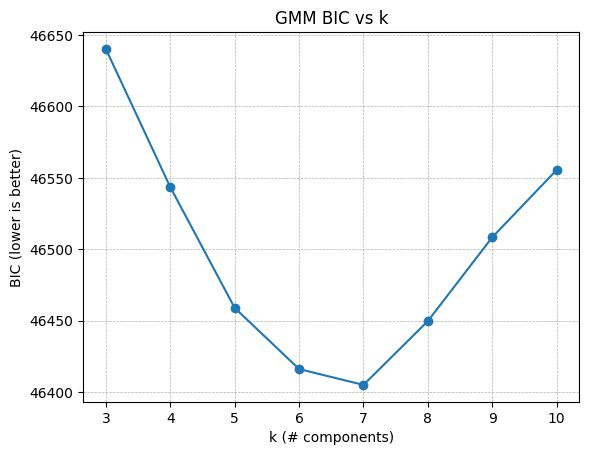

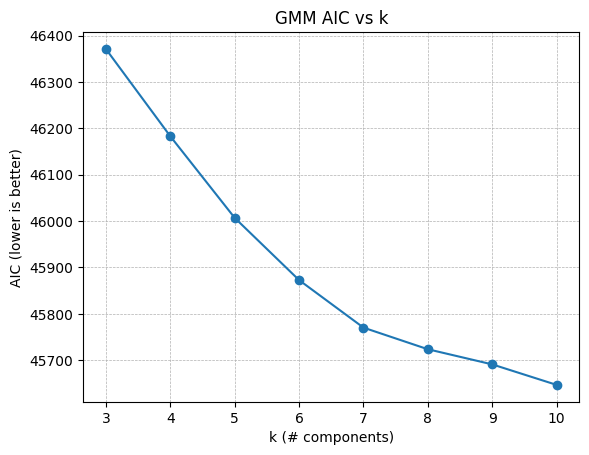

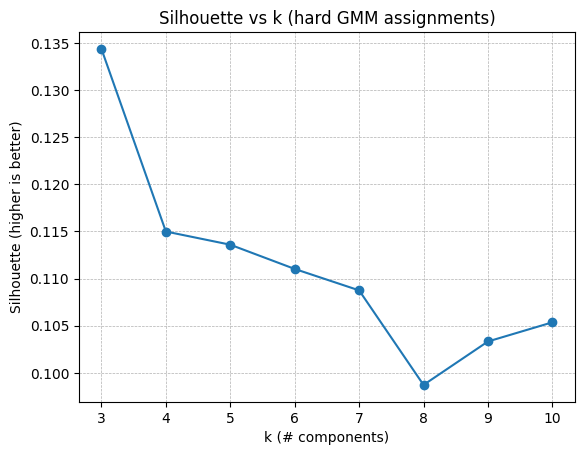

In [36]:
# ----------------------------
# Plot model selection curves
# ----------------------------
ks = eval_df["k"].values
bics = eval_df["bic"].values
aics = eval_df["aic"].values
sils = eval_df["silhouette"].values

plt.figure()
plt.plot(ks, bics, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("BIC (lower is better)")
plt.title("GMM BIC vs k")
plt.xticks(ks)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, aics, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("AIC (lower is better)")
plt.title("GMM AIC vs k")
plt.xticks(ks)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, sils, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("Silhouette (higher is better)")
plt.title("Silhouette vs k (hard GMM assignments)")
plt.xticks(ks)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [38]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ----------------------------
# Clustering metrics on labeled anchors (40 points)
# ----------------------------
# A) Cluster assignment vs true label (permutation-invariant; best clustering eval)
ari_cluster = adjusted_rand_score(y_lab, cl_lab)
nmi_cluster = normalized_mutual_info_score(y_lab, cl_lab)

print(f"\n[Anchors] ARI (true labels vs clusters): {ari_cluster:.3f}")
print(f"[Anchors] NMI (true labels vs clusters): {nmi_cluster:.3f}")

# B) Mapped predicted label vs true label (tests your cluster->label mapping)
# Only evaluate where mapping exists (cluster had labeled anchors)
mapped_labels = np.array([cluster_to_label[c] for c in cl_lab], dtype=object)
valid = np.array([m is not None for m in mapped_labels], dtype=bool)

if valid.sum() > 0:
    ari_mapped = adjusted_rand_score(y_lab[valid], mapped_labels[valid].astype(int))
    nmi_mapped = normalized_mutual_info_score(y_lab[valid], mapped_labels[valid].astype(int))
    print(f"\n[Anchors] ARI (true labels vs mapped PredictedLabel): {ari_mapped:.3f}")
    print(f"[Anchors] NMI (true labels vs mapped PredictedLabel): {nmi_mapped:.3f}")
else:
    print("\n[Anchors] No valid mapped labels available to compute mapped ARI/NMI.")



[Anchors] ARI (true labels vs clusters): 0.191
[Anchors] NMI (true labels vs clusters): 0.411

[Anchors] ARI (true labels vs mapped PredictedLabel): 0.502
[Anchors] NMI (true labels vs mapped PredictedLabel): 0.463


In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_anchor = mapped_labels.astype(int)
print("\n[Anchors] Accuracy (majority-vote reason):", accuracy_score(y_lab, y_pred_anchor))
print("\n[Anchors] Confusion matrix:\n", confusion_matrix(y_lab, y_pred_anchor))
print("\n[Anchors] Classification report:\n", classification_report(y_lab, y_pred_anchor, digits=3))



[Anchors] Accuracy (majority-vote reason): 0.8

[Anchors] Confusion matrix:
 [[ 9  0  1]
 [ 3  5  2]
 [ 2  0 18]]

[Anchors] Classification report:
               precision    recall  f1-score   support

           1      0.643     0.900     0.750        10
           2      1.000     0.500     0.667        10
           3      0.857     0.900     0.878        20

    accuracy                          0.800        40
   macro avg      0.833     0.767     0.765        40
weighted avg      0.839     0.800     0.793        40



In [40]:
# Convert cluster purity dict to array for vectorized lookup
purity_arr = np.array([cluster_purity.get(c, 0.0) for c in range(best_k)], dtype=float)

business_conf = confidence * purity_arr[cluster]  # (posterior) x (label purity of cluster)

result["BusinessConfidence"] = business_conf

hc_unlabeled = (unlabeled_mask) & (business_conf >= CONF_THRESH) & (pred_label != None)
print(f"\nHigh-confidence unlabeled assignments using BusinessConfidence (>= {CONF_THRESH}): "
      f"{int(hc_unlabeled.sum())} out of {int(unlabeled_mask.sum())}")


High-confidence unlabeled assignments using BusinessConfidence (>= 0.85): 266 out of 1560


Loaded 1600 rows | Labeled 40 | Unlabeled 1560 | Labels: [1, 2, 3]
NCA transformed shape: (1600, 8) (n_components=8)

Model selection table:
 k          bic          aic  silhouette  ari_anchors  nmi_anchors
 3 46656.420258 46387.532313    0.137218     0.245306     0.365116
 4 46541.148563 46180.838716    0.112777     0.186937     0.331429
 5 46469.983231 46018.251482    0.111847     0.173351     0.283628
 6 46419.038657 45875.885008    0.108363     0.307880     0.511725
 7 46402.026606 45767.451055    0.106462     0.240994     0.456726
 8 46468.710130 45742.712678    0.104557     0.201421     0.434667
 9 46500.951083 45683.531729    0.102595     0.133333     0.392117
10 46572.292767 45663.451512    0.104684     0.135114     0.384081

Chosen k by BIC: 7


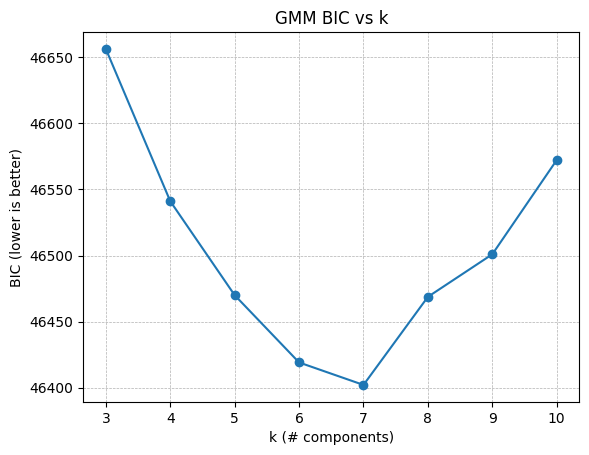

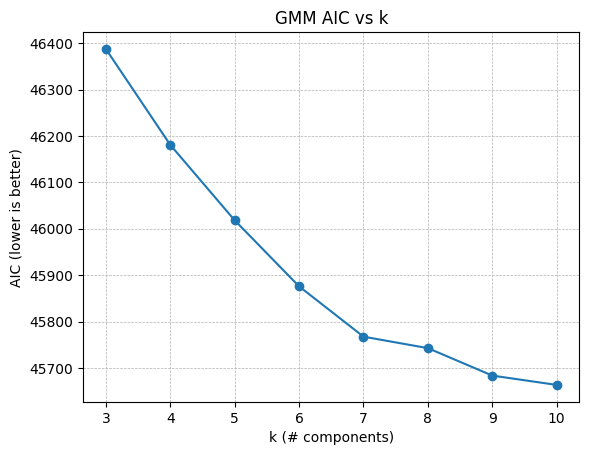

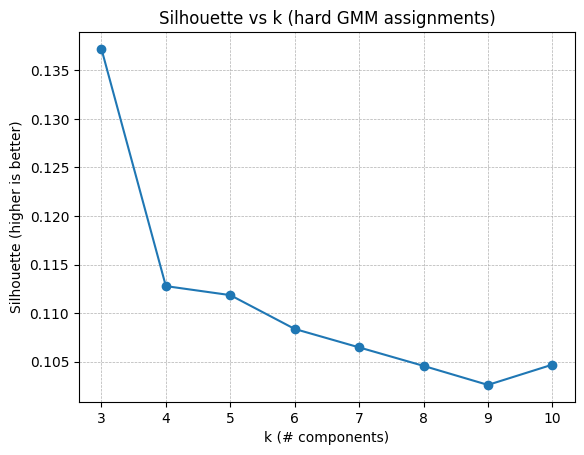

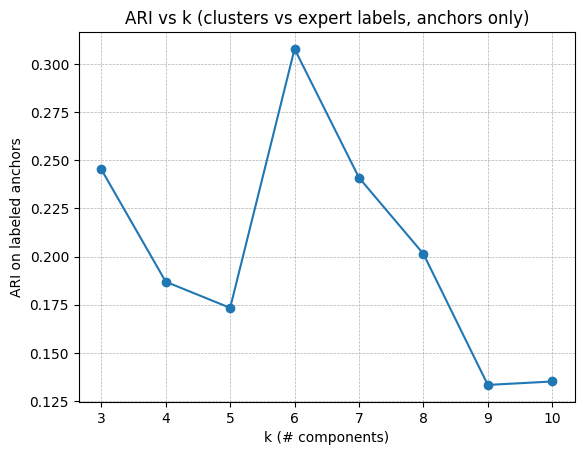

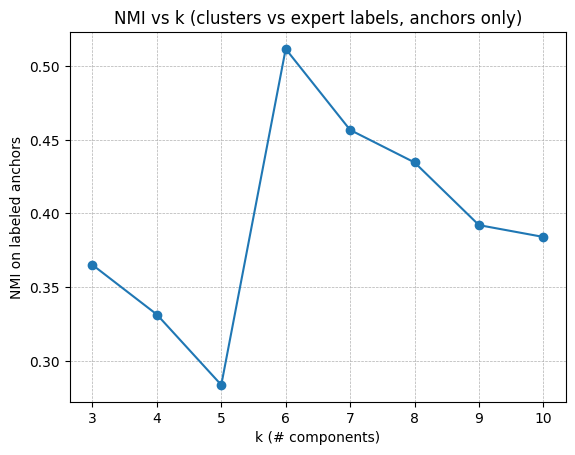


Cluster sizes: {0: 260, 1: 233, 2: 182, 3: 249, 4: 191, 5: 211, 6: 274}

Cluster -> Label mapping (majority vote on labeled anchors): {0: 3, 1: 3, 2: 3, 3: 2, 4: 1, 5: 1, 6: 1}
Cluster purities: {0: 0.8571428571428571, 1: 1.0, 2: 1.0, 3: 1.0, 4: 0.5, 5: 0.75, 6: 0.5}
Cluster labeled support (# labeled points per cluster): {0: 7, 1: 5, 2: 6, 3: 6, 4: 2, 5: 8, 6: 6}

[Anchors] Anchor agreement (majority-vote label): 0.825
[Anchors] ARI (true labels vs clusters): 0.241
[Anchors] NMI (true labels vs clusters): 0.457

[Anchors] Accuracy (majority-vote reason): 0.825

[Anchors] Confusion matrix:
 [[10  0  0]
 [ 3  6  1]
 [ 3  0 17]]

[Anchors] Classification report:
               precision    recall  f1-score   support

           1      0.625     1.000     0.769        10
           2      1.000     0.600     0.750        10
           3      0.944     0.850     0.895        20

    accuracy                          0.825        40
   macro avg      0.856     0.817     0.805        40
wei

In [2]:
"""
Semi-supervised pipeline: NCA (trained on the labeled anchors) + GMM on ALL points
with k chosen via BIC, plus evaluation on labeled anchors and better confidence.

Updates included:
- Plots BIC/AIC/Silhouette curves
- Computes ARI/NMI vs clusters (on labeled anchors) for EACH k (and plots them)
- Computes cluster->label mapping + purity at best_k
- Computes classification metrics on anchors for mapped labels
- Defines BusinessConfidence = (max GMM posterior) * (cluster purity on anchors)
- Counts high-confidence unlabeled using BusinessConfidence
- Saves results CSV

Assumes CSV columns:
- Sensor columns start with "Sensor"
- Label column is "Label" with NaN for unlabeled and ints for labeled (e.g., 1,2,3)

Run:
python script.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "./data_sensors (1).csv"
SENSOR_PREFIX = "Sensor"

# NCA
NCA_DIM = 8
NCA_MAX_ITER = 2000
NCA_TOL = 1e-5
RANDOM_STATE = 42

# GMM model selection
K_MIN = 3
K_MAX = 10
COV_TYPE = "diag"       # try: "diag" or "full"
N_INIT = 10
REG_COVAR = 1e-6

# Confidence threshold for auto-labeling (BusinessConfidence)
CONF_THRESH = 0.85

# ----------------------------
# Load + prep
# ----------------------------
df = pd.read_csv(CSV_PATH)

sensor_cols = [c for c in df.columns if c.startswith(SENSOR_PREFIX)]
if not sensor_cols:
    raise ValueError(f"No sensor columns found with prefix '{SENSOR_PREFIX}'")

if "Label" not in df.columns:
    raise ValueError("Expected a 'Label' column with NaN for unlabeled and ints for labeled.")

X = df[sensor_cols].values.astype("float64")
y_raw = df["Label"].values

labeled_mask = ~pd.isna(y_raw)
unlabeled_mask = ~labeled_mask

if labeled_mask.sum() < 5:
    raise ValueError("Too few labeled points to train NCA meaningfully.")

y_l = y_raw[labeled_mask].astype(int)
if len(np.unique(y_l)) < 2:
    raise ValueError("NCA needs at least 2 distinct labels in the labeled subset.")

print(f"Loaded {len(df)} rows | Labeled {labeled_mask.sum()} | Unlabeled {unlabeled_mask.sum()} | Labels: {sorted(np.unique(y_l).tolist())}")

# ----------------------------
# Scale (fit on ALL data)
# ----------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 1) Train NCA on labeled points only
# ----------------------------
nca = NeighborhoodComponentsAnalysis(
    n_components=min(NCA_DIM, X_scaled.shape[1]),
    max_iter=NCA_MAX_ITER,
    tol=NCA_TOL,
    random_state=RANDOM_STATE,
)

X_l_scaled = X_scaled[labeled_mask]
nca.fit(X_l_scaled, y_l)

# Transform ALL points (labeled + unlabeled)
Z = nca.transform(X_scaled)
print(f"NCA transformed shape: {Z.shape} (n_components={Z.shape[1]})")

# ----------------------------
# 2) GMM selection by BIC over k + per-k anchor metrics
# ----------------------------
rows = []
gmms = {}

for k in range(K_MIN, K_MAX + 1):
    gmm = GaussianMixture(
        n_components=k,
        covariance_type=COV_TYPE,
        n_init=N_INIT,
        reg_covar=REG_COVAR,
        random_state=RANDOM_STATE,
    )
    gmm.fit(Z)

    bic = gmm.bic(Z)
    aic = gmm.aic(Z)

    hard = gmm.predict(Z)

    # Silhouette on all points (hard assignments)
    sil = np.nan
    if 1 < len(np.unique(hard)) < len(Z):
        sil = silhouette_score(Z, hard)

    # Anchor-only ARI/NMI vs cluster IDs (true labels vs clusters)
    cl_lab_k = hard[labeled_mask]
    ari_k = adjusted_rand_score(y_l, cl_lab_k)
    nmi_k = normalized_mutual_info_score(y_l, cl_lab_k)

    rows.append(
        {
            "k": k,
            "bic": bic,
            "aic": aic,
            "silhouette": sil,
            "ari_anchors": ari_k,
            "nmi_anchors": nmi_k,
        }
    )
    gmms[k] = gmm

eval_df = pd.DataFrame(rows).sort_values("k")
print("\nModel selection table:")
print(eval_df.to_string(index=False))

best_k = int(eval_df.loc[eval_df["bic"].idxmin(), "k"])
best_gmm = gmms[best_k]
print(f"\nChosen k by BIC: {best_k}")

# ----------------------------
# Plot model selection curves
# ----------------------------
ks = eval_df["k"].values

plt.figure()
plt.plot(ks, eval_df["bic"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("BIC (lower is better)")
plt.title("GMM BIC vs k")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["aic"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("AIC (lower is better)")
plt.title("GMM AIC vs k")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["silhouette"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("Silhouette (higher is better)")
plt.title("Silhouette vs k (hard GMM assignments)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["ari_anchors"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("ARI on labeled anchors")
plt.title("ARI vs k (clusters vs expert labels, anchors only)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["nmi_anchors"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("NMI on labeled anchors")
plt.title("NMI vs k (clusters vs expert labels, anchors only)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ----------------------------
# 3) Fit best GMM + compute assignments/confidence
# ----------------------------
cluster = best_gmm.predict(Z)
post = best_gmm.predict_proba(Z)
gmm_conf = post.max(axis=1)  # max posterior component probability

# Cluster sizes
u, cts = np.unique(cluster, return_counts=True)
sizes = dict(zip(u.tolist(), cts.tolist()))
print("\nCluster sizes:", sizes)

# ----------------------------
# 4) Evaluate using labeled anchors: cluster purity + mapping
# ----------------------------
cluster_to_label = {}
cluster_purity = {}
cluster_support = {}

cl_lab = cluster[labeled_mask]
y_lab = y_l

for c in range(best_k):
    idx = np.where(cl_lab == c)[0]
    cluster_support[c] = int(len(idx))
    if len(idx) == 0:
        cluster_to_label[c] = None
        cluster_purity[c] = 0.0
        continue

    labels_here = y_lab[idx]
    vals, counts = np.unique(labels_here, return_counts=True)
    maj_label = int(vals[np.argmax(counts)])
    purity = float(counts.max() / counts.sum())

    cluster_to_label[c] = maj_label
    cluster_purity[c] = purity

# Majority-vote predicted reason for anchors
mapped_anchor = np.array([cluster_to_label[c] for c in cl_lab], dtype=object)
valid_anchor = np.array([m is not None for m in mapped_anchor], dtype=bool)

anchor_agreement = float(np.mean(mapped_anchor[valid_anchor].astype(int) == y_lab[valid_anchor]))
ari_cluster = adjusted_rand_score(y_lab, cl_lab)
nmi_cluster = normalized_mutual_info_score(y_lab, cl_lab)

print("\nCluster -> Label mapping (majority vote on labeled anchors):", cluster_to_label)
print("Cluster purities:", cluster_purity)
print("Cluster labeled support (# labeled points per cluster):", cluster_support)
print(f"\n[Anchors] Anchor agreement (majority-vote label): {anchor_agreement:.3f}")
print(f"[Anchors] ARI (true labels vs clusters): {ari_cluster:.3f}")
print(f"[Anchors] NMI (true labels vs clusters): {nmi_cluster:.3f}")

# Classification-style metrics on anchors (mapped labels)
if valid_anchor.sum() > 0:
    y_pred_anchor = mapped_anchor[valid_anchor].astype(int)
    print("\n[Anchors] Accuracy (majority-vote reason):", accuracy_score(y_lab[valid_anchor], y_pred_anchor))
    print("\n[Anchors] Confusion matrix:\n", confusion_matrix(y_lab[valid_anchor], y_pred_anchor))
    print("\n[Anchors] Classification report:\n", classification_report(y_lab[valid_anchor], y_pred_anchor, digits=3))

# Predicted label for all points (None where cluster had no labeled anchors)
pred_label = np.array([cluster_to_label.get(c, None) for c in cluster], dtype=object)

# ----------------------------
# 5) Better confidence: BusinessConfidence = GMM posterior * cluster purity
# ----------------------------
purity_arr = np.array([cluster_purity.get(c, 0.0) for c in range(best_k)], dtype=float)
business_conf = gmm_conf * purity_arr[cluster]

# High-confidence unlabeled assignments using BusinessConfidence
hc_unlabeled = (unlabeled_mask) & (business_conf >= CONF_THRESH) & (pred_label != None)
print(f"\nHigh-confidence unlabeled assignments using BusinessConfidence (>= {CONF_THRESH}): "
      f"{int(hc_unlabeled.sum())} out of {int(unlabeled_mask.sum())}")

# ----------------------------
# 6) Save results
# ----------------------------
result = df.copy()
result["NCA_dim"] = Z.shape[1]
result["GMM_k"] = best_k
result["Cluster"] = cluster
result["GMMConfidence"] = gmm_conf
result["ClusterPurity"] = purity_arr[cluster]
result["BusinessConfidence"] = business_conf
result["PredictedLabel"] = pred_label

OUT_PATH = "./nca_gmm_bic_results.csv"
result.to_csv(OUT_PATH, index=False)
print("\nSaved:", OUT_PATH)


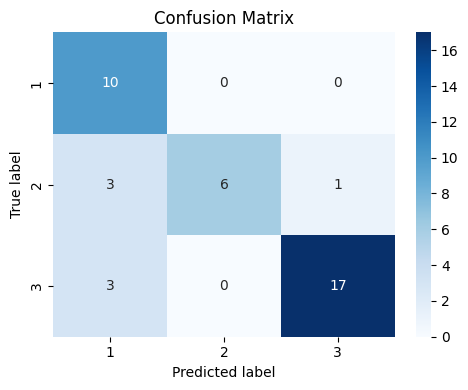

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# True vs predicted labels on anchors
y_true = y_lab
y_pred = np.array([cluster_to_label[c] for c in cl_lab], dtype=int)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[1, 2, 3],
    yticklabels=[1, 2, 3],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


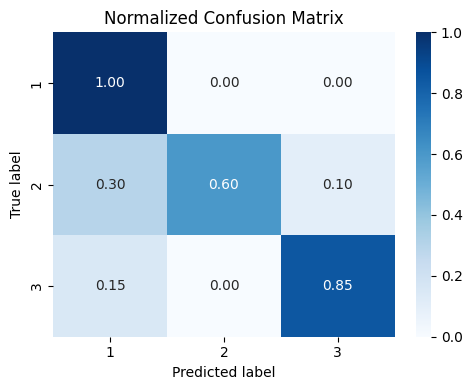

In [4]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[1, 2, 3],
    yticklabels=[1, 2, 3],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


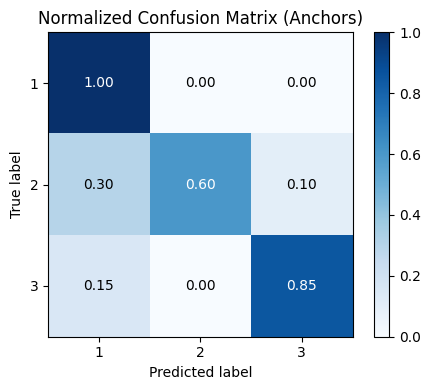

In [5]:
plt.figure(figsize=(5, 4))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (Anchors)")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, [1, 2, 3])
plt.yticks(tick_marks, [1, 2, 3])

thresh = cm_norm.max() / 2
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha="center", va="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


With CV

Loaded 1600 rows | Labeled 40 | Unlabeled 1560 | Labels: [1, 2, 3] | Counts: {1: 10, 2: 10, 3: 20}

CV RESULTS (anchors only, leakage-safe)
 fold  best_k_bic  ari_test  nmi_test  acc_test_mapped  macro_f1_test_mapped  hc_unlabeled_count  test_mapped_coverage
    1           7  0.030769  0.533333            0.500              0.490476                 111                   1.0
    2           8 -0.029412  0.495475            0.625              0.611111                 529                   1.0
    3           7  0.023256  0.421908            0.250              0.261905                  65                   1.0
    4          10 -0.029412  0.495475            0.250              0.206349                 640                   1.0
    5          10 -0.129032  0.500000            0.375              0.281481                 525                   1.0
[CV] ari_test: mean=-0.027 std=0.057
[CV] nmi_test: mean=0.489 std=0.037
[CV] acc_test_mapped: mean=0.400 std=0.146
[CV] macro_f1_test_mapped: mea

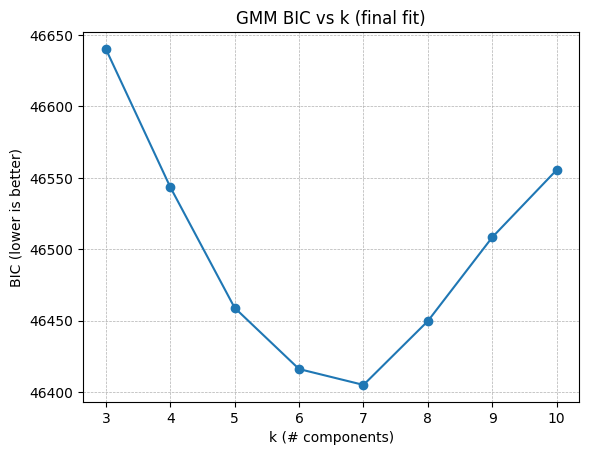

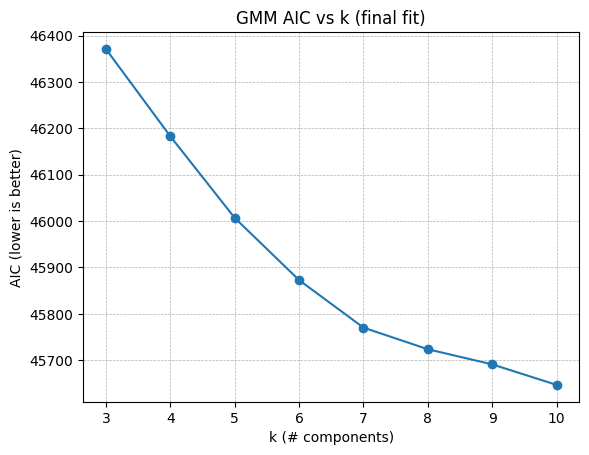

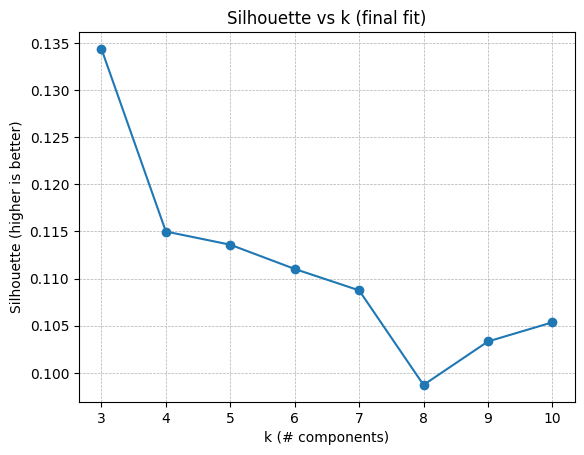


Cluster sizes: {0: 216, 1: 259, 2: 212, 3: 283, 4: 247, 5: 184, 6: 199}

Cluster -> Label mapping (majority vote on ALL anchors): {0: 3, 1: 2, 2: 3, 3: 1, 4: 3, 5: 3, 6: 1}
Cluster purities: {0: 0.8, 1: 1.0, 2: 1.0, 3: 0.5, 4: 0.75, 5: 1.0, 6: 0.75}
Cluster labeled support (# labeled points per cluster): {0: 5, 1: 5, 2: 2, 3: 6, 4: 8, 5: 6, 6: 8}

[Anchors - optimistic] Accuracy: 0.8

[Anchors - optimistic] Confusion matrix:
 [[ 9  0  1]
 [ 3  5  2]
 [ 2  0 18]]

[Anchors - optimistic] Classification report:
               precision    recall  f1-score   support

           1      0.643     0.900     0.750        10
           2      1.000     0.500     0.667        10
           3      0.857     0.900     0.878        20

    accuracy                          0.800        40
   macro avg      0.833     0.767     0.765        40
weighted avg      0.839     0.800     0.793        40


[Anchors - optimistic] ARI: 0.191
[Anchors - optimistic] NMI: 0.411

High-confidence unlabeled assignm

In [10]:
"""
Semi-supervised pipeline: NCA (trained on labeled anchors) + GMM on ALL points
with k chosen via BIC.

Adds: CV evaluation on anchors WITHOUT leakage:
- StratifiedKFold over labeled anchors
- Fit scaler + NCA on train anchors only
- Fit GMM on ALL points in the transformed space
- Build cluster->label mapping & purity using TRAIN anchors only
- Evaluate on TEST anchors only (accuracy, macro-F1, confusion, ARI/NMI)

Also:
- Plots BIC/AIC/Silhouette curves (for final fit)
- Saves results CSV (final fit)

Assumes CSV columns:
- Sensor columns start with "Sensor"
- Label column is "Label" with NaN for unlabeled and ints for labeled (e.g., 1,2,3)

Run:
python script.py
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
)

# ----------------------------
# Config
# ----------------------------
CSV_PATH = "./data_sensors (1).csv"
SENSOR_PREFIX = "Sensor"

# NCA
NCA_DIM = 8
NCA_MAX_ITER = 2000
NCA_TOL = 1e-5

# GMM model selection
K_MIN = 3
K_MAX = 10
COV_TYPE = "diag"       # try: "diag" or "full"
N_INIT = 10
REG_COVAR = 1e-6

# Confidence threshold for auto-labeling (BusinessConfidence)
CONF_THRESH = 0.85

# CV on anchors
CV_FOLDS = 5
CV_SEED = 0
CV_SHUFFLE = True

# ----------------------------
# Helpers
# ----------------------------
def fit_gmm_select_k(Z_all, random_state):
    """Fit GMMs for k in [K_MIN, K_MAX], return best_k by BIC and table + dict of gmms."""
    rows = []
    gmms = {}
    for k in range(K_MIN, K_MAX + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=COV_TYPE,
            n_init=N_INIT,
            reg_covar=REG_COVAR,
            random_state=random_state,
        )
        gmm.fit(Z_all)

        bic = gmm.bic(Z_all)
        aic = gmm.aic(Z_all)
        hard = gmm.predict(Z_all)

        sil = np.nan
        if 1 < len(np.unique(hard)) < len(Z_all):
            sil = silhouette_score(Z_all, hard)

        rows.append({"k": k, "bic": bic, "aic": aic, "silhouette": sil})
        gmms[k] = gmm

    eval_df = pd.DataFrame(rows).sort_values("k")
    best_k = int(eval_df.loc[eval_df["bic"].idxmin(), "k"])
    return best_k, eval_df, gmms


def cluster_mapping_and_purity(cluster_train, y_train, k):
    """
    Build cluster->label mapping via majority vote using TRAIN anchors only.
    Also returns per-cluster purity and labeled support.
    """
    cluster_to_label = {}
    cluster_purity = {}
    cluster_support = {}

    for c in range(k):
        idx = np.where(cluster_train == c)[0]
        cluster_support[c] = int(len(idx))
        if len(idx) == 0:
            cluster_to_label[c] = None
            cluster_purity[c] = 0.0
            continue

        labels_here = y_train[idx]
        vals, counts = np.unique(labels_here, return_counts=True)
        maj_label = int(vals[np.argmax(counts)])
        purity = float(counts.max() / counts.sum())

        cluster_to_label[c] = maj_label
        cluster_purity[c] = purity

    return cluster_to_label, cluster_purity, cluster_support


def safe_is_not_none(arr_obj):
    """Boolean mask where elements are not None (works reliably for object arrays)."""
    return np.array([x is not None for x in arr_obj], dtype=bool)

# ----------------------------
# Load + prep
# ----------------------------
df = pd.read_csv(CSV_PATH)

sensor_cols = [c for c in df.columns if c.startswith(SENSOR_PREFIX)]
if not sensor_cols:
    raise ValueError(f"No sensor columns found with prefix '{SENSOR_PREFIX}'")

if "Label" not in df.columns:
    raise ValueError("Expected a 'Label' column with NaN for unlabeled and ints for labeled.")

X = df[sensor_cols].values.astype("float64")
y_raw = df["Label"].values

labeled_mask = ~pd.isna(y_raw)
unlabeled_mask = ~labeled_mask

if labeled_mask.sum() < 5:
    raise ValueError("Too few labeled points to train NCA meaningfully.")

y_l = y_raw[labeled_mask].astype(int)
classes, class_counts = np.unique(y_l, return_counts=True)

if len(classes) < 2:
    raise ValueError("NCA needs at least 2 distinct labels in the labeled subset.")

print(
    f"Loaded {len(df)} rows | Labeled {labeled_mask.sum()} | Unlabeled {unlabeled_mask.sum()} | "
    f"Labels: {sorted(classes.tolist())} | Counts: {dict(zip(classes.tolist(), class_counts.tolist()))}"
)

# Adjust folds if any class too small
min_class = int(class_counts.min())
if CV_FOLDS > min_class:
    new_folds = max(2, min_class)
    print(f"[CV] Reducing CV_FOLDS from {CV_FOLDS} to {new_folds} due to small class counts.")
    CV_FOLDS = new_folds

# Indices of labeled anchors in original dataset
idx_labeled = np.where(labeled_mask)[0]

# ----------------------------
# CV evaluation on anchors (no leakage)
# ----------------------------
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=CV_SHUFFLE, random_state=CV_SEED)

cv_rows = []
fold_num = 0

for train_pos, test_pos in skf.split(idx_labeled, y_l):
    fold_num += 1

    train_idx = idx_labeled[train_pos]  # indices in full dataset
    test_idx = idx_labeled[test_pos]

    # ----- Fit scaler on TRAIN anchors only (leakage-safe) -----
    scaler = StandardScaler()
    scaler.fit(X[train_idx])
    X_scaled_all = scaler.transform(X)

    # ----- Fit NCA on TRAIN anchors only -----
    nca = NeighborhoodComponentsAnalysis(
        n_components=min(NCA_DIM, X_scaled_all.shape[1]),
        max_iter=NCA_MAX_ITER,
        tol=NCA_TOL,
        random_state=CV_SEED + fold_num,  # small variation per fold
    )
    nca.fit(X_scaled_all[train_idx], y_raw[train_idx].astype(int))
    Z_all = nca.transform(X_scaled_all)

    # ----- Fit/select GMM on ALL points in transformed space -----
    best_k, eval_df, gmms = fit_gmm_select_k(Z_all, random_state=CV_SEED + fold_num)
    best_gmm = gmms[best_k]

    cluster_all = best_gmm.predict(Z_all)
    post_all = best_gmm.predict_proba(Z_all)
    gmm_conf_all = post_all.max(axis=1)

    # ----- Mapping + purity from TRAIN anchors only -----
    cluster_train = cluster_all[train_idx]
    y_train = y_raw[train_idx].astype(int)

    cluster_to_label, cluster_purity, cluster_support = cluster_mapping_and_purity(
        cluster_train=cluster_train, y_train=y_train, k=best_k
    )

    # Predict label for all points (None if cluster had no labeled train anchors)
    pred_label_all = np.array([cluster_to_label.get(c, None) for c in cluster_all], dtype=object)
    pred_is_valid_all = safe_is_not_none(pred_label_all)

    # ----- BusinessConfidence using TRAIN purity -----
    purity_arr = np.array([cluster_purity.get(c, 0.0) for c in range(best_k)], dtype=float)
    business_conf_all = gmm_conf_all * purity_arr[cluster_all]

    # High-confidence unlabeled count in this fold
    hc_unlabeled = unlabeled_mask & (business_conf_all >= CONF_THRESH) & pred_is_valid_all
    hc_unlabeled_count = int(hc_unlabeled.sum())

    # ----- Evaluate on TEST anchors only -----
    y_test = y_raw[test_idx].astype(int)
    cluster_test = cluster_all[test_idx]

    # ARI/NMI on test anchors: true labels vs cluster IDs
    ari_test = adjusted_rand_score(y_test, cluster_test)
    nmi_test = normalized_mutual_info_score(y_test, cluster_test)

    # Classification-style metrics: map cluster->label from TRAIN and score on TEST
    pred_test = pred_label_all[test_idx]
    pred_test_valid = safe_is_not_none(pred_test)

    acc = np.nan
    f1m = np.nan
    if pred_test_valid.sum() > 0:
        y_pred_test = pred_test[pred_test_valid].astype(int)
        y_true_test = y_test[pred_test_valid]
        acc = accuracy_score(y_true_test, y_pred_test)
        f1m = f1_score(y_true_test, y_pred_test, average="macro")

    cv_rows.append(
        {
            "fold": fold_num,
            "best_k_bic": best_k,
            "ari_test": ari_test,
            "nmi_test": nmi_test,
            "acc_test_mapped": acc,
            "macro_f1_test_mapped": f1m,
            "hc_unlabeled_count": hc_unlabeled_count,
            "test_mapped_coverage": float(pred_test_valid.mean()),
        }
    )

cv_df = pd.DataFrame(cv_rows)

print("\n====================")
print("CV RESULTS (anchors only, leakage-safe)")
print("====================")
print(cv_df.to_string(index=False))

def mean_std(col):
    vals = cv_df[col].values.astype(float)
    return np.nanmean(vals), np.nanstd(vals)

for metric in ["ari_test", "nmi_test", "acc_test_mapped", "macro_f1_test_mapped", "test_mapped_coverage"]:
    m, s = mean_std(metric)
    print(f"[CV] {metric}: mean={m:.3f} std={s:.3f}")

print(f"[CV] High-confidence unlabeled (>= {CONF_THRESH}) avg: {cv_df['hc_unlabeled_count'].mean():.1f} "
      f"(std={cv_df['hc_unlabeled_count'].std():.1f}) out of {int(unlabeled_mask.sum())}")

# ----------------------------
# FINAL FIT (train on ALL anchors) + plots + CSV export
# ----------------------------
print("\n====================")
print("FINAL FIT (train on all anchors) for deployment artifact")
print("====================")

# Scale (fit on ALL data) — fine for final training artifact
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train NCA on ALL labeled anchors
nca = NeighborhoodComponentsAnalysis(
    n_components=min(NCA_DIM, X_scaled.shape[1]),
    max_iter=NCA_MAX_ITER,
    tol=NCA_TOL,
    random_state=CV_SEED,
)
nca.fit(X_scaled[labeled_mask], y_l)
Z = nca.transform(X_scaled)
print(f"NCA transformed shape: {Z.shape} (n_components={Z.shape[1]})")

# Select k by BIC, fit best model
best_k, eval_df, gmms = fit_gmm_select_k(Z, random_state=CV_SEED)
best_gmm = gmms[best_k]
print("\nModel selection table (final fit):")
print(eval_df.to_string(index=False))
print(f"\nChosen k by BIC (final): {best_k}")

# Plot model selection curves (final fit)
ks = eval_df["k"].values

plt.figure()
plt.plot(ks, eval_df["bic"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("BIC (lower is better)")
plt.title("GMM BIC vs k (final fit)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["aic"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("AIC (lower is better)")
plt.title("GMM AIC vs k (final fit)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

plt.figure()
plt.plot(ks, eval_df["silhouette"].values, marker="o")
plt.xlabel("k (# components)")
plt.ylabel("Silhouette (higher is better)")
plt.title("Silhouette vs k (final fit)")
plt.xticks(ks)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Assignments/confidence
cluster = best_gmm.predict(Z)
post = best_gmm.predict_proba(Z)
gmm_conf = post.max(axis=1)

# Cluster sizes
u, cts = np.unique(cluster, return_counts=True)
sizes = dict(zip(u.tolist(), cts.tolist()))
print("\nCluster sizes:", sizes)

# Mapping + purity using ALL anchors (for deployment artifact)
cl_lab = cluster[labeled_mask]
y_lab = y_l

cluster_to_label, cluster_purity, cluster_support = cluster_mapping_and_purity(
    cluster_train=cl_lab, y_train=y_lab, k=best_k
)

print("\nCluster -> Label mapping (majority vote on ALL anchors):", cluster_to_label)
print("Cluster purities:", cluster_purity)
print("Cluster labeled support (# labeled points per cluster):", cluster_support)

# Anchor evaluation (note: optimistic; CV above is the honest estimate)
mapped_anchor = np.array([cluster_to_label[c] for c in cl_lab], dtype=object)
valid_anchor = safe_is_not_none(mapped_anchor)

if valid_anchor.sum() > 0:
    y_pred_anchor = mapped_anchor[valid_anchor].astype(int)
    y_true_anchor = y_lab[valid_anchor]
    print("\n[Anchors - optimistic] Accuracy:", accuracy_score(y_true_anchor, y_pred_anchor))
    print("\n[Anchors - optimistic] Confusion matrix:\n", confusion_matrix(y_true_anchor, y_pred_anchor))
    print("\n[Anchors - optimistic] Classification report:\n", classification_report(y_true_anchor, y_pred_anchor, digits=3))
    print(f"\n[Anchors - optimistic] ARI: {adjusted_rand_score(y_true_anchor, cl_lab[valid_anchor]):.3f}")
    print(f"[Anchors - optimistic] NMI: {normalized_mutual_info_score(y_true_anchor, cl_lab[valid_anchor]):.3f}")

# Predicted label for all points
pred_label = np.array([cluster_to_label.get(c, None) for c in cluster], dtype=object)

# BusinessConfidence = posterior * cluster purity
purity_arr = np.array([cluster_purity.get(c, 0.0) for c in range(best_k)], dtype=float)
business_conf = gmm_conf * purity_arr[cluster]

hc_unlabeled = (unlabeled_mask) & (business_conf >= CONF_THRESH) & safe_is_not_none(pred_label)
print(f"\nHigh-confidence unlabeled assignments (final) using BusinessConfidence (>= {CONF_THRESH}): "
      f"{int(hc_unlabeled.sum())} out of {int(unlabeled_mask.sum())}")

# Save results
result = df.copy()
result["NCA_dim"] = Z.shape[1]
result["GMM_k"] = best_k
result["Cluster"] = cluster
result["GMMConfidence"] = gmm_conf
result["ClusterPurity"] = purity_arr[cluster]
result["BusinessConfidence"] = business_conf
result["PredictedLabel"] = pred_label

OUT_PATH = "./nca_gmm_bic_results.csv"
result.to_csv(OUT_PATH, index=False)
print("\nSaved:", OUT_PATH)
